In [885]:
import collections
from datetime import datetime as dt
from datetime import timedelta
from edgar import Company
import graphviz
import json
import lxml.html as lh
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pandas_datareader as pdr
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import re
import requests
import sec_scraper
import time
import warnings
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
plotly.offline.init_notebook_mode()
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.svm import SVC
from yellowbrick.regressor import ResidualsPlot

In [72]:
# Functions for getting the CIK and Company Name from a SPAC ticker

def get_ticker_to_cik(write=False):
    # local copy: data/ticker_to_cik.txt
    ticker_to_cik = pd.read_csv('https://www.sec.gov/include/ticker.txt',
                                sep='\t', header=None, names=['ticker','cik'])
    if write:
        ticker_to_cik.to_csv('data/ticker_to_cik.csv', index=False)
    ticker_to_cik['ticker'] = ticker_to_cik.ticker.str.upper()
    ticker_to_cik['cik'] = ticker_to_cik.cik.astype(str)
    return ticker_to_cik

def get_cik_to_name(write=False):
    # local copy: data/cik_to_name.json
    cik_to_name = pd.read_json('https://www.sec.gov/files/company_tickers.json').transpose()
    if write:
        cik_to_name.to_csv('data/cik_to_name.csv', index=False)
    cik_to_name['ticker'] = cik_to_name.ticker.str.upper()
    cik_to_name['cik'] = cik_to_name.cik_str.astype(str)
    return cik_to_name

def process_spac_lists(file_path_current, file_path_past, write=False):
    # current spac list
    spac_list_current = pd.read_csv(file_path_current)
    spac_list_current = spac_list_current.Ticker.unique()
    spac_list_current = pd.DataFrame(spac_list_current, columns=['Ticker'])
    
    # past spac list (completed business combination)
    spac_list_past = pd.read_csv(file_path_past)
    spac_list_past.fillna('missing', inplace=True)
    spac_list_past['dupe_filter'] = spac_list_past['Old Ticker'] + spac_list_past['New Ticker']
    spac_list_past = spac_list_past[spac_list_past.dupe_filter.isin(spac_list_past.dupe_filter.unique())]
    spac_list_past.drop(columns=['dupe_filter'], inplace=True)
    
    # write to file
    if write==True:
        spac_list_current.to_csv('spac_list_current.csv', index=False)
        spac_list_past.to_csv('spac_list_past.csv', index=False)
    
    # get ticker to cik and cik to company name file, then merge
    ticker_to_cik = get_ticker_to_cik(write=write)
    cik_to_name = get_cik_to_name(write=write)
    spac_list_past = spac_list_past.merge(ticker_to_cik, how='left', left_on='New Ticker', right_on='ticker')
    spac_list_past = spac_list_past.merge(ticker_to_cik, how='left', left_on='Old Ticker', right_on='ticker')
    spac_list_past.rename(columns={'ticker_x':'ticker','cik_x':'cik','cik_y':'cik_old'}, inplace=True)
    spac_list_past.drop(columns='ticker_y', inplace=True)
    spac_list_past = spac_list_past.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    spac_list_current = spac_list_current.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    spac_list_current = spac_list_current.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    
    # some current spacs have not split from units to stock + warrants so ticker in sec different
    ticker_unit = pd.DataFrame(spac_list_current[spac_list_current.ticker.isna()]['Ticker'])
    ticker_unit['Ticker'] = ticker_unit.Ticker + 'U'
    ticker_unit = ticker_unit.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    ticker_unit = ticker_unit.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    ticker_unit['Ticker'] = ticker_unit.Ticker.apply(lambda x: x[:-1] if not pd.isnull(x) else x)
    ticker_unit['ticker'] = ticker_unit.ticker.apply(lambda x: x[:-1] if not pd.isnull(x) else x)
    ticker_unit_other = pd.DataFrame(ticker_unit[ticker_unit.ticker.isna()]['Ticker'])
    ticker_unit_other['Ticker'] = ticker_unit_other.Ticker.apply(lambda x: x+'-UN')
    ticker_unit_other = ticker_unit_other.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    ticker_unit_other = ticker_unit_other.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    ticker_unit_other['Ticker'] = ticker_unit_other.Ticker.apply(lambda x: x[:-3] if not pd.isnull(x) else x)
    ticker_unit_other['ticker'] = ticker_unit_other.ticker.apply(lambda x: x[:-3] if not pd.isnull(x) else x)
    ticker_unit = ticker_unit.append(ticker_unit_other)
    ticker_unit.dropna(inplace=True)
    
    # append tickers found using 'U' and '-UN'
    spac_list_current = spac_list_current[~spac_list_current.Ticker.isin(ticker_unit.Ticker)]
    spac_list_current = spac_list_current.append(ticker_unit)
    
    print('count current spacs:', len(spac_list_current))
    print('count nan in current spacs:', len(spac_list_current[spac_list_current.ticker.isna()]))
    print('count past spacs:', len(spac_list_past))
    print('count nan in past spacs:', len(spac_list_past[spac_list_past.ticker.isna()]))
    
    return spac_list_current, spac_list_past

In [73]:
# Functions for pulling 8-K html, converting to text, grabbing date, and simple classifier

def clean_text(text):
    text = text.replace('\n',' ').replace('\xa0',' ')
    text = re.sub(' +', ' ', text) # remove extra spaces
    text = text.lower()
    return text

# def form_html_to_text(forms_html):
#     forms_text = []
#     for form_html in forms_html:
#         form_text = clean_text(form_html.text_content())
#         forms_text.append(form_text)
#     return forms_text

# def date_parser_primary(split_text):
#     # handle case: "november 13 (november 8, 2019)""
#     if '(' in split_text[1] and ',' not in split_text[1].split('(')[0]:
#         monthday_split = split_text[1].split('(')[0]
#         year_split = split_text[1].split('(')[1].split(', ')[1].split(')')[0]
#         date_string = monthday_split.replace(' ','') + ', ' + year_split.replace(')','')
#     # handle cases:
#     # "november 13, 2019"
#     # "november 13, 2019 (november 15, 2019)"...uses first date
#     # "july [   ], 2019"...return None
#     else:
#         split_text = split_text[1].split(', ')
#         if '[' in split_text[0]:
#             return None
#         date_string = split_text[0].replace(' ','') + ', ' + split_text[1].replace(' ','')[0:4]
#     date_dt = dt.strptime(date_string, '%B%d, %Y')
#     date_dt = date_dt.strftime('%Y-%m-%d')
#     return date_dt

# def date_parser_secondary(split_text):
#     # handle case when date comes before "date of report..." string
#     split_text = split_text[0].split(', ')
#     monthday_split = split_text[len(split_text)-2].split(' ')
#     month = monthday_split[len(monthday_split)-2].replace('1934','').replace('(','') # case: 1934June
#     day = monthday_split[len(monthday_split)-1]
#     year = split_text[len(split_text)-1].replace(' ','')[0:4]
#     date_string = str(month)+str(day)+', '+str(year)
#     date_dt = dt.strptime(date_string, '%B%d, %Y')
#     date_dt = date_dt.strftime('%Y-%m-%d')
#     return date_dt

# TODO: handle duplicate dates (sometime multiple 8-Ks on same date)
# def create_date_text_df(forms_text, form_type):
#     df = pd.DataFrame()
#     for form_text in forms_text:
#         date_case_1 = 'date of report (date of earliest event reported):'
#         date_case_2 = 'date of report (date earliest event reported):'
#         date_case_3 = 'date of earliest event reported:'
#         date_case_4 = 'date of report (date of earliest event reported)'
#         if len(form_text.split(date_case_1))>1:
#             split_text = form_text.split(date_case_1)
#             date_dt = date_parser_primary(split_text)
#         elif len(form_text.split(date_case_2))>1:
#             split_text = form_text.split(date_case_2)
#             date_dt = date_parser_primary(split_text)
#         elif len(form_text.split(date_case_3))>1:
#             split_text = form_text.split(date_case_3)
#             date_dt = date_parser_primary(split_text)
#         elif len(form_text.split(date_case_4))>1:
#             split_text = form_text.split(date_case_4)
#             date_dt = date_parser_secondary(split_text)
#         else:
#             print('none of the date identifiers worked. skipping this form...')
#             continue
#         df = df.append(pd.Series([date_dt, form_type, form_text]), ignore_index=True)
#     if len(df)!=0:
#         df.columns = ['date','form','text']
#     return df

# def get_forms_text(company_name, cik_id, form_type):
#     print(company_name)
#     company = Company(company_name, cik_id)
#     print('url to forms:', company.get_filings_url(filing_type=form_type, ownership='include', no_of_entries=100))
#     forms_site_html = company.get_all_filings(filing_type=form_type, ownership='include', no_of_entries=100)
#     forms_html = company.get_documents(forms_site_html, no_of_documents=100, debug=False)
#     forms_text = form_html_to_text(forms_html)
#     if len(forms_text)==0:
#         return
#     df = create_date_text_df(forms_text, form_type)
#     return df

def get_forms_text(company_name, cik_id, form_type):
    c = sec_scraper.Company(company_name, cik_id)
    filings = c.get_all_filings(filing_type=form_type, no_of_documents=100)
    dates = [f.accepted_date for f in filings]
    documents = [clean_text(f.documents[0]) for f in filings]
    print(company_name, cik_id)
    df = pd.DataFrame(list(zip(dates, documents)), columns=['date','text'])
    df['form'] = '8-K'
    df['accepted_time'] = df.date
    df['date'] = df.date.apply(lambda x: x[0:10])
    return df

def simple_text_match(df_form, substring):
    df_form[substring.replace(' ','_')+'_found'] = df_form.text.apply(lambda x: 1 if substring in x else 0)
    return df_form

In [74]:
# Functions for grabbing and saving price data

def bulk_save_prices_to_csv(symbols, start_date, end_date, price_source, is_warrant=False):
    for ind, symbol in enumerate(symbols):
        print(symbol)
        df_prices = get_historical_prices(symbol=symbol,
                                          start_date=start_date,
                                          end_date=end_date,
                                          price_source=price_source,
                                          is_warrant=is_warrant)
        if df_prices is not None:
            df_prices = process_historical_prices(df_prices)
            df_prices.to_csv('data/prices_'+price_source+'/'+symbol+'_prices.csv', index=False)
        # TD and alphavantage limits query rate
        if ind%10==0 and ind!=0:
            time.sleep(30)
        
def run_bulk_save_prices(spac_list_current, spac_list_past, price_source, is_warrant=False):
    # spacs missing price data entirely
    missing_past_spacs = ['missing', 'LCAH', 'FMCI1', 'CFCO']
    missing_current_spacs = ['ACNDU', 'ARYB', 'BRLI', 'DFHT', 'DMYD', 'FUSE', 'GOAC', 'IWAC', 'LCAH', 'LGVW',
                             'MCAC', 'MLAC', 'PANA', 'PSAC', 'PSTH', 'SSMC', 'TREB']
    
    symbols_past_new_ticker = [x for x in spac_list_past.ticker.unique().tolist() if str(x)!='nan']
    symbols_past_old_ticker = spac_list_past['Old Ticker'].unique().tolist()
    symbols_past_old_ticker = [x for x in symbols_past_old_ticker if x not in missing_past_spacs]
    symbols_current = [x for x in spac_list_current['Ticker'] if x not in missing_current_spacs]
    if is_warrant:
        symbols_past_new_ticker = [x + 'W' for x in symbols_past_new_ticker]
        symbols_past_old_ticker = [x + 'W' for x in symbols_past_old_ticker]
        symbols_current = [x + 'W' for x in symbols_current]
    bulk_save_prices_to_csv(symbols=symbols_past_new_ticker, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
    bulk_save_prices_to_csv(symbols=symbols_past_old_ticker, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
    bulk_save_prices_to_csv(symbols=symbols_current, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
        
def load_saved_prices_data(symbol, price_source):
    df_prices = pd.read_csv('data/prices_'+price_source+'/'+symbol+'_prices.csv') 
    print('price data min date:', df_prices.date.min())
    print('price data max date:', df_prices.date.max())
    return df_prices

def get_td_key_locally():
    f = open("data/td_consumer_key.txt", "r")
    return f.read()

def millis_since_epoch_to_dt(x):
    return dt.fromtimestamp(float(x)/1000).strftime('%Y-%m-%d %H:%M:%S.%f')

def dt_to_millis_since_epoch(x):
    epoch = dt.utcfromtimestamp(0)
    return str(int((x-epoch).total_seconds()*1000))

def get_prices_td(symbol, start_date, end_date, minute_freq=False):
    TD_CONSUMER_KEY = get_td_key_locally()
    start_date_epoch = dt_to_millis_since_epoch(dt.strptime(start_date, '%Y-%m-%d'))
    end_date_epoch = dt_to_millis_since_epoch(dt.strptime(end_date, '%Y-%m-%d'))
    partial_url = 'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory?'
    # minute-to-minute prices (<2 months available)
    if minute_freq:
        endpoint = partial_url+'periodType=day&frequencyType=minute&startDate={start_date}&endDate={end_date}'
    # daily open-close prices
    else:
        endpoint = partial_url+'periodType=month&frequencyType=daily&startDate={start_date}&endDate={end_date}'
    full_url = endpoint.format(symbol=symbol,
                               start_date=start_date_epoch,
                               end_date=end_date_epoch)
    page = requests.get(url=full_url, params={'apikey' : TD_CONSUMER_KEY})
    content = json.loads(page.content)
    try:
        df_td_prices = pd.DataFrame.from_dict(content['candles'])
    except:
        return None
    if len(df_td_prices)==0:
        return None
    df_td_prices['datetime'] = df_td_prices.datetime.apply(lambda x: millis_since_epoch_to_dt(x))
    df_td_prices['date'] = df_td_prices.datetime.apply(lambda x: x[0:10])
    df_td_prices['ticker'] = symbol
    return df_td_prices

def get_historical_prices(symbol, start_date, end_date, price_source, is_warrant=False):
    print('getting prices from', start_date, 'to', end_date, 'for', symbol)
    if price_source=='td':
        df_prices = get_prices_td(symbol, start_date, end_date)
        if df_prices is None and is_warrant:
            df_prices = get_prices_td(symbol[:-1]+'.WS', start_date, end_date)
    else:
        start_split = start_date.split('-')
        end_split = end_date.split('-')
        start = dt(int(start_split[0]), int(start_split[1]), int(start_split[2]))
        end = dt(int(end_split[0]), int(end_split[1]), int(end_split[2]))
        try:
            # be careful with missing/limited data in yahoo data
            if price_source=='yahoo':
                df_prices = pdr.data.DataReader(name=symbol, data_source='yahoo', start=start, end=end)
            # alphavantage seems to be most reliable. 5 calls per minute and 500 calls per day
            if price_source=='alphavantage':
                df_prices = pdr.data.DataReader(name=symbol, data_source='av-daily', start=start, end=end,
                                                api_key='BDB9WJQRCZKINCLD')
            # iex has extremely limited api calls
            if price_source=='iex':
                df_prices = pdr.data.DataReader(name=symbol, data_source='iex', start=start, end=end,
                                                api_key='pk_970dfff359894b15a056cf677c02e11f')
            df_prices.reset_index(inplace=True)
            df_prices.rename(columns={'index':'date'}, inplace=True)
        except:
            return None
    return df_prices

def process_historical_prices(df_prices):
    df_prices.columns = df_prices.columns.str.lower()
    df_prices['date'] = df_prices.date.astype(str)
    df_prices['close_t+1'] = df_prices.close.shift(-1)
    df_prices['close_t+3'] = df_prices.close.shift(-3)
    df_prices['close_t+5'] = df_prices.close.shift(-5)
    df_prices['close_t+7'] = df_prices.close.shift(-7)
    df_prices['open_close_t+1_%chg'] = (df_prices['close_t+1'] - df_prices['open']) / df_prices['open']
    df_prices['open_close_t+3_%chg'] = (df_prices['close_t+3'] - df_prices['open']) / df_prices['open']
    df_prices['open_close_t+5_%chg'] = (df_prices['close_t+5'] - df_prices['open']) / df_prices['open']
    df_prices['open_close_t+7_%chg'] = (df_prices['close_t+7'] - df_prices['open']) / df_prices['open']
    df_prices = df_prices.round(2)
    print('output min date:', df_prices.date.min())
    print('output max date:', df_prices.date.max())
    return df_prices

In [80]:
# Functions outputting dataframe of 8-Ks, classification, and 1,3,5,7 day returns

def agg_spac_returns(spac_list, price_source, is_warrant=False):
    df_returns_agg = pd.DataFrame()
    for ind in range(0, len(spac_list)):
        row = spac_list.iloc[ind]
        print('index:', ind)
        print(row.ticker)
        
        broken_current_spacs = ['GNRS','KBLM','LGC','LIVE','NOVS']
        if is_warrant:
            broken_current_spacs = [x + 'W' for x in broken_current_spacs]
        if row.ticker in broken_current_spacs:
            print('in broken spac list, skipping...')
            continue

        # get form 8Ks
        df_form_8K = get_forms_text(company_name=row.title, cik_id=row.cik, form_type='8-K')
        if df_form_8K is None or len(df_form_8K)==0:
            print('no 8Ks found, trying cik_old...')
            if 'cik_old' in row.index:
                df_form_8K = get_forms_text(company_name=row.title, cik_id=row.cik_old, form_type='8-K')
        if df_form_8K is None or len(df_form_8K)==0:
            print('no 8Ks found, skipping...\n')
            continue
            
        # simple classifier
        df_form_8K = simple_text_match(df_form_8K, 'letter of intent')
        df_form_8K = simple_text_match(df_form_8K, 'business combination agreement')

        # get stock prices
        try:
            df_prices = load_saved_prices_data(row.ticker, price_source)
        except:
            df_prices = get_historical_prices(symbol=row.ticker,
                                              start_date='2018-01-01',
                                              end_date=dt.today().strftime('%Y-%m-%d'),
                                              price_source=price_source,
                                              is_warrant=is_warrant)
        if df_prices is None:
            print('prices for', row.ticker, 'not found. skipping...\n')
            continue
        df_prices = process_historical_prices(df_prices)

        # output returns per form
        df_returns = df_form_8K.merge(df_prices[['date','open_close_t+1_%chg','open_close_t+3_%chg',
                                                 'open_close_t+5_%chg','open_close_t+7_%chg']],
                                      how='left', on='date')
        display(df_returns)

        # aggregate
        if len(df_returns)!=0:
            df_returns['symbol'] = row.ticker
        df_returns_agg = df_returns_agg.append(df_returns)
        
        # sec site sometimes will timeout
        if ind%30==0 and ind!=0:
            time.sleep(120)
        
    # drop duplicates on date + symbol
    df_returns_agg = df_returns_agg.drop_duplicates(subset=['date','symbol'])
    
    return df_returns_agg

def load_all_spacs(use_saved=True, write=False):
    if use_saved:
        df_returns_past = pd.read_csv('data/df_returns_past.csv')
        df_returns_current = pd.read_csv('data/df_returns_current.csv')
        df_returns_past_warrants_newticker = pd.read_csv('data/df_returns_past_warrants_newticker.csv')
        df_returns_past_warrants_oldticker = pd.read_csv('data/df_returns_past_warrants_oldticker.csv')
        df_returns_current_warrants = pd.read_csv('data/df_returns_current_warrants.csv')
        return df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
    else:
        # get returns following 8-Ks for past spacs
        df_returns_past = agg_spac_returns(spac_list_past, price_source='td')

        # get returns following 8-Ks for current spacs
        df_returns_current = agg_spac_returns(spac_list_current, price_source='td')

        # get returns following 8-Ks for past spac warrants (new and old tickers)
        spac_list_past_warrants_newticker = spac_list_past.copy()
        spac_list_past_warrants_newticker['ticker'] = spac_list_past_warrants_newticker['New Ticker'] + 'W' # warrants
        df_returns_past_warrants_newticker = agg_spac_returns(spac_list_past_warrants_newticker,
                                                              price_source='td',
                                                              is_warrant=True)
        spac_list_past_warrants_oldticker = spac_list_past.copy()
        spac_list_past_warrants_oldticker['ticker'] = spac_list_past_warrants_oldticker['Old Ticker'] + 'W' # warrants
        df_returns_past_warrants_oldticker = agg_spac_returns(spac_list_past_warrants_oldticker,
                                                              price_source='td',
                                                              is_warrant=True)

        # get returns following 8-Ks for current spac warrants
        spac_list_current_warrants = spac_list_current.copy()
        spac_list_current_warrants['ticker'] = spac_list_current_warrants.Ticker + 'W' # warrants
        df_returns_current_warrants = agg_spac_returns(spac_list_current_warrants,
                                                       price_source='td',
                                                       is_warrant=True)

        if write:
            df_returns_past.to_csv('data/df_returns_past.csv', index=False)
            df_returns_current.to_csv('data/df_returns_current.csv', index=False)
            df_returns_past_warrants_newticker.to_csv('data/df_returns_past_warrants_newticker.csv', index=False)
            df_returns_past_warrants_oldticker.to_csv('data/df_returns_past_warrants_oldticker.csv', index=False)
            df_returns_current_warrants.to_csv('data/df_returns_current_warrants.csv', index=False)
    return df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants

In [81]:
# load current and past spac lists
spac_list_current, spac_list_past = process_spac_lists(file_path_current='data/spac_list_current.csv',
                                                       file_path_past='data/spac_list_past.csv',
                                                       write=False)

# bulk save price data for symbols in spac lists (due to API limits)...no need to run if already saved
# run_bulk_save_prices(spac_list_current, spac_list_past, price_source='td', is_warrant=False)
# run_bulk_save_prices(spac_list_current, spac_list_past, price_source='td', is_warrant=True)

count current spacs: 133
count nan in current spacs: 6
count past spacs: 52
count nan in past spacs: 7


In [126]:
# load returns for all spacs
df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved=True, write=False)

## Analysis

In [412]:
# Functions for backtest
# note .123 is 12.3% in output

def compute_mean_returns(df_returns, corrupt_symbols, includes_hourly=False):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    if includes_hourly:
        agg_dict = {'accepted_time_t+1hr_%chg':'mean','accepted_time_t+3hr_%chg':'mean',
                    'accepted_time_t+5hr_%chg':'mean','accepted_time_t+7hr_%chg':'mean',
                    'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    else:
        agg_dict = {'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    df_mean_returns = df_returns[~df_returns.symbol.isin(corrupt_symbols)].groupby('symbol').agg(agg_dict)
    df_mean_returns.dropna(inplace=True)
    print('Count:', len(df_mean_returns))
    return np.round(df_mean_returns, 3)

def summary_statistics(df_returns, corrupt_symbols):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    return np.round(df_returns[~df_returns.symbol.isin(corrupt_symbols)].dropna().describe(), 3)

def compute_mean_returns_LOI(df_returns, corrupt_symbols, includes_hourly=False):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    if includes_hourly:
        agg_dict = {'accepted_time_t+1hr_%chg':'mean','accepted_time_t+3hr_%chg':'mean',
                    'accepted_time_t+5hr_%chg':'mean','accepted_time_t+7hr_%chg':'mean',
                    'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    else:
        agg_dict = {'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean'}
    return np.round(df_returns[(~df_returns.symbol.isin(corrupt_symbols)) &
                               (df_returns.letter_of_intent_found==1)].dropna().groupby('symbol').agg(agg_dict), 3)

Past SPACs (Stock)

In [109]:
print('mean returns for past spac stocks')
compute_mean_returns(df_returns_past, corrupt_symbols=['ACEL']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac stocks
Count: 38


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
IGIC                 -0.040               -0.110               -0.200   
HYMC                 -0.013               -0.102                0.668   
SONG                  0.030               -0.090               -0.090   
KXIN                 -0.073               -0.071               -0.073   
TH                   -0.062               -0.066               -0.062   
KERN                 -0.049               -0.066               -0.054   
AVCT                 -0.052               -0.059               -0.071   
KLR                  -0.030               -0.053               -0.049   
NSCO                 -0.025               -0.036               -0.053   
IMVT                 -0.010               -0.032               -0.042   
IMTX                 -0.008               -0.028               -0.028   
AESE                 -0.027               -0.028                0.002   
GTYH                 -0.014               -0.024               -0.021   
BRMK                 -0.010               -0.023               -0.034   
GSMG                 -0.008               -0.020                0.073   
SPCE                 -0.007               -0.018               -0.023   
ATCX                 -0.000               -0.018               -0.018   
ROSE                 -0.034               -0.018                0.016   
PACK                 -0.008               -0.018               -0.022   
SMPL                 -0.010               -0.014               -0.018   
WSC                  -0.002               -0.003               -0.003   
BRQS                 -0.011               -0.002               -0.013   
RPAY                 -0.000               -0.002                0.028   
FG                    0.003                0.002                0.001   
HOFV                 -0.005                0.004               -0.008   
MGY                   0.000                0.006                0.004   
SG                    0.018                0.006               -0.001   
PRTH                  0.004                0.017                0.015   
AHCO                  0.005                0.020                0.027   
XYNO                 -0.045                0.021                0.008   
CCC                   0.033                0.023                0.002   
DKNG                  0.022                0.034                0.036   
LAZY                  0.002                0.036                0.037   
GTEC                  0.067                0.064                0.116   
VVNT                 -0.022                0.083                0.018   
WTRH                 -0.015                0.108                0.049   
LPRO                  0.060                0.120                0.120   
NKLA                  0.105                0.131                0.244   

        open_close_t+7_%chg  
symbol                       
IGIC                 -0.140  
HYMC                  0.674  
SONG                  0.020  
KXIN                 -0.083  
TH                   -0.060  
KERN                 -0.052  
AVCT                 -0.092  
KLR                  -0.051  
NSCO                 -0.048  
IMVT                 -0.000  
IMTX                 -0.037  
AESE                  0.008  
GTYH                 -0.044  
BRMK                 -0.021  
GSMG                  0.128  
SPCE                 -0.040  
ATCX                  0.006  
ROSE                 -0.002  
PACK                 -0.032  
SMPL                  0.003  
WSC                  -0.011  
BRQS                 -0.031  
RPAY                  0.040  
FG                    0.006  
HOFV                 -0.010  
MGY                   0.011  
SG                   -0.027  
PRTH                  0.007  
AHCO                  0.028  
XYNO                  0.043  
CCC                  -0.000  
DKNG                  0.076  
LAZY                  0.006  
GTEC                  0.095  
VVNT   

In [110]:
print('summary stats for returns in past spac stocks')
summary_statistics(df_returns_past, corrupt_symbols=['ACEL'])

summary stats for returns in past spac stocks


letter_of_intent_found  business_combination_agreement_found  \
count                 731.000                               731.000   
mean                    0.003                                 0.038   
std                     0.052                                 0.192   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              731.000              731.000              731.000   
mean                -0.011               -0.004                0.006   
std                  0.118                0.274                0.337   
min                 -0.660               -0.900               -0.900   
25%                 -0.040               -0.060               -0.070   
50%                  0.000                0.000                0.000   
75%                  0.020                0.020                0.030   
max                  1.110                6.220                6.860   

       open_close_t+7_%chg  
count              731.000  
mean                 0.003  
std                  0.331  
min                 -0.900  
25%                 -0.070  
50%                  0.000  
75%                  0.040  
max                  6.940

In [111]:
print('mean returns for past spac stocks (LOI text match)')
compute_mean_returns_LOI(df_returns_past, corrupt_symbols=['ACEL']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac stocks (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
AVCT                  -0.01                -0.02                -0.02   
BRQS                   0.05                 0.02                 0.02   

        open_close_t+7_%chg  
symbol                       
AVCT                  -0.02  
BRQS                   0.03

Current SPACs (Stock)

In [112]:
print('mean returns for current spac stocks')
compute_mean_returns(df_returns_current, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac stocks
Count: 50


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
TZAC                 -0.065               -0.060               -0.055   
INSU                 -0.044               -0.055               -0.048   
CRSA                 -0.047               -0.053               -0.057   
OPES                 -0.015               -0.044               -0.021   
GRAF                 -0.014               -0.014               -0.001   
NFIN                 -0.020               -0.010               -0.020   
FPAC                 -0.002               -0.009               -0.010   
JFK                  -0.010               -0.008                0.005   
TOTA                 -0.007               -0.007               -0.003   
LHC                  -0.004               -0.006               -0.005   
LACQ                 -0.002               -0.005               -0.007   
HECCU                -0.005               -0.005               -0.005   
BRPA                 -0.003               -0.003               -0.003   
PACQ                 -0.005               -0.001               -0.002   
LFAC                  0.000                0.000                0.000   
ACAM                  0.000                0.000                0.000   
MCMJ                  0.000                0.000                0.000   
OAC                   0.000                0.000                0.000   
RMG                   0.000                0.000                0.000   
ROCHU                 0.000                0.000                0.000   
SAMA                  0.010                0.000               -0.003   
LOAC                  0.020                0.000                0.020   
MNCL                  0.000                0.000                0.000   
ZGYH                  0.010                0.000                0.005   
ALAC                  0.001                0.000                0.003   
FVAC                  0.000                0.000                0.010   
FTAC                  0.000                0.000                0.000   
JFKKU                 0.005                0.000                0.005   
ANDA                  0.000                0.000                0.010   
THCB                  0.000                0.003                0.010   
AMCI                  0.003                0.003                0.000   
GIX                   0.002                0.005                0.020   
SPAQ                 -0.075                0.007                0.017   
CFFA                  0.003                0.007                0.011   
MFAC                  0.000                0.008                0.005   
JIH                  -0.005                0.010                0.005   
SHLL                  0.070                0.010                0.270   
RPLA                  0.000                0.010                0.010   
JEF                   0.011                0.011                0.004   
PAAC                 -0.047                0.013               -0.005   
LCA                   0.080                0.015               -0.070   
CCX                   0.015                0.015                0.000   
SBE                   0.010                0.020                0.010   
IPV                   0.000                0.020                0.010   
HCCH                 -0.002                0.028                0.020   
FEAC                  0.010                0.030                0.030   
CCH                   0.015                0.065                0.055   
FMCI                  0.040                0.110                0.117   
LPRO                  0.060                0.120                0.120   
BMRG                  0.110                0.130                0.100   

        open_close_t+7_%chg  
symbol                       
TZAC                 -0.060  
INSU                 -0.050  
CRSA                 -0.060  
OPES                  0.018  
GRAF                 -0.003  
N

In [113]:
print('summary stats for returns in current spac stocks')
summary_statistics(df_returns_current, corrupt_symbols=[])

summary stats for returns in current spac stocks


letter_of_intent_found  business_combination_agreement_found  \
count                 241.000                               241.000   
mean                    0.041                                 0.120   
std                     0.200                                 0.326   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              241.000              241.000              241.000   
mean                 0.001                0.003                0.006   
std                  0.044                0.052                0.065   
min                 -0.280               -0.280               -0.310   
25%                  0.000                0.000                0.000   
50%                 -0.000               -0.000                0.000   
75%                  0.010                0.010                0.010   
max                  0.180                0.310                0.540   

       open_close_t+7_%chg  
count              241.000  
mean                 0.009  
std                  0.087  
min                 -0.350  
25%                 -0.010  
50%                  0.000  
75%                  0.010  
max                  0.720

In [114]:
print('mean returns for current spac stocks (LOI text match)')
compute_mean_returns_LOI(df_returns_current, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac stocks (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFIN                 -0.020               -0.010               -0.020   
ALAC                  0.005                0.000                0.010   
PAAC                  0.000                0.000                0.000   
SAMA                  0.010                0.000               -0.010   
MFAC                  0.000                0.010                0.020   
OPES                  0.180                0.060                0.290   
FMCI                  0.050                0.125                0.155   
BMRG                  0.110                0.130                0.100   

        open_close_t+7_%chg  
symbol                       
NFIN                 -0.010  
ALAC                  0.015  
PAAC                  0.000  
SAMA                  0.000  
MFAC                  0.050  
OPES                  0.650  
FMCI                  0.080  
BMRG                  0.120

Past SPAC Warrants

In [413]:
print('mean returns for past spac warrants')
compute_mean_returns(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac warrants
Symbols removed: ['LAZYW']
Count: 32


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
GTECW                -0.183               -0.153               -0.087   
NSCOW                -0.073               -0.099               -0.019   
IMTXW                -0.070               -0.073               -0.072   
AVCTW                -0.049               -0.065               -0.090   
AESEW                -0.038               -0.064                0.042   
IMVTW                -0.034               -0.060               -0.082   
GSMGW                -0.044               -0.057                0.077   
KERNW                -0.043               -0.044                0.001   
ACELW                -0.010               -0.040               -0.047   
SPCEW                -0.011               -0.031               -0.018   
BRMKW                 0.020               -0.031               -0.020   
KXINW                 0.024               -0.031               -0.064   
ATCXW                 0.009               -0.015               -0.021   
WTRHW                 0.005               -0.008                0.019   
SMPLW                -0.019               -0.005               -0.022   
THW                  -0.007               -0.004               -0.005   
SONGW                 0.120                0.000               -0.050   
PACKW                 0.013                0.013                0.027   
GTYHW                 0.036                0.014               -0.001   
FGW                   0.016                0.019               -0.035   
CCCW                  0.080                0.020                0.000   
MGYW                  0.011                0.025                0.019   
RPAYW                 0.023                0.029                0.076   
HYMCW                 0.034                0.032                0.013   
VVNTW                -0.063                0.040                0.007   
PRTHW                 0.075                0.046                0.151   
NKLAW                 0.117                0.058                0.220   
AHCOW                 0.020                0.062                0.078   
ROSEW                 0.036                0.089                0.082   
KLRW                  0.133                0.096                0.075   
HOFVW                 0.097                0.327                0.497   
BRQSW                 0.208                0.363                0.138   

        open_close_t+7_%chg  
symbol                       
GTECW                -0.087  
NSCOW                -0.026  
IMTXW                -0.132  
AVCTW                -0.060  
AESEW                -0.012  
IMVTW                -0.002  
GSMGW                 0.092  
KERNW                 0.002  
ACELW                -0.009  
SPCEW                -0.052  
BRMKW                 0.039  
KXINW                -0.089  
ATCXW                 0.005  
WTRHW                -0.005  
SMPLW                 0.000  
THW                  -0.005  
SONGW                 0.170  
PACKW                 0.035  
GTYHW                -0.030  
FGW                  -0.034  
CCCW                 -0.160  
MGYW                  0.040  
RPAYW                 0.107  
HYMCW                 0.032  
VVNTW                 0.062  
PRTHW                 0.095  
NKLAW                 0.181  
AHCOW                 0.081  
ROSEW                 0.154  
KLRW                  0.151  
HOFVW                 0.572  
BRQSW                 0.027

In [417]:
print('summary stats for returns in past spac warrants')
summary_statistics(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW'])

summary stats for returns in past spac warrants
Symbols removed: ['LAZYW']


letter_of_intent_found  business_combination_agreement_found  \
count                 490.000                               490.000   
mean                    0.002                                 0.045   
std                     0.045                                 0.207   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              490.000              490.000              490.000   
mean                 0.014                0.019                0.041   
std                  0.198                0.278                0.414   
min                 -0.730               -0.930               -0.880   
25%                 -0.060               -0.100               -0.120   
50%                  0.000                0.000               -0.010   
75%                  0.060                0.090                0.110   
max                  1.500                3.170                4.670   

       open_close_t+7_%chg  
count              490.000  
mean                 0.051  
std                  0.418  
min                 -0.730  
25%                 -0.120  
50%                  0.000  
75%                  0.130  
max                  4.500

In [415]:
print('mean returns for past spac warrants (LOI text match)')
compute_mean_returns_LOI(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW']).sort_values(by='open_close_t+3_%chg')

mean returns for past spac warrants (LOI text match)
Symbols removed: ['LAZYW']


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
AVCTW                  0.85                 0.77                 0.92   

        open_close_t+7_%chg  
symbol                       
AVCTW                  0.46

Current SPAC Warrants

In [118]:
print('mean returns for current spac warrants')
compute_mean_returns(df_returns_current_warrants, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac warrants
Count: 47


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ORSNW                -0.335               -0.430               -0.265   
CRSAW                -0.255               -0.350               -0.380   
TOTAW                -0.220               -0.220                0.110   
BRPAW                 0.425               -0.205                1.685   
SAMAW                -0.070               -0.197                0.050   
INSUW                -0.148               -0.147               -0.140   
LOACW                -0.034               -0.080               -0.144   
LFACW                -0.035               -0.062               -0.073   
LACQW                -0.013               -0.061               -0.063   
JIHW                 -0.020               -0.060                0.060   
ALACW                 0.043               -0.051               -0.029   
RMGW                  0.000               -0.050                0.000   
CCXXW                -0.210               -0.040               -0.010   
THCBW                -0.027               -0.040               -0.007   
GRAFW                 0.058               -0.032                0.083   
LIVKW                -0.190               -0.030               -0.160   
SHLLW                 0.060               -0.020                0.850   
OPESW                -0.013               -0.012                0.143   
FPACW                -0.032               -0.011               -0.031   
LHCW                 -0.011               -0.006                0.019   
GIXW                  0.050               -0.005                0.360   
CFFAW                -0.037               -0.004                0.060   
SSPKW                 0.070                0.000                0.190   
ZGYHW                 0.320                0.000                0.260   
MFACW                 0.017                0.010               -0.100   
PAACW                -0.078                0.010                0.202   
LCAHW                 0.170                0.025                0.035   
TDACW                -0.065                0.030                0.640   
FVACW                 0.090                0.030                0.160   
NFINW                 0.330                0.030                0.300   
FEACW                 0.070                0.030                0.050   
ANDAW                 0.050                0.050                0.260   
PACQW                -0.018                0.066               -0.155   
MNCLW                 0.025                0.105                0.075   
CCHW                  0.095                0.130                0.120   
NEBUW                 0.153                0.141                0.177   
ACTTW                 0.093                0.147                0.109   
AMCIW                 0.138                0.300                0.438   
HCCHW                 0.288                0.335                0.375   
RPLAW                 0.310                0.360                0.330   
CCXW                  0.160                0.360                0.200   
SBEW                  0.090                0.430                0.620   
FMCIW                 0.586                0.707                0.899   
TZACW                 0.095                0.740                1.025   
AGBAW                 1.000                1.000                1.000   
SPAQW                -0.030                1.050                1.530   
BMRGW                 1.100                1.440                1.000   

        open_close_t+7_%chg  
symbol                       
ORSNW                -0.250  
CRSAW                -0.425  
TOTAW                 0.560  
BRPAW                -0.255  
SAMAW                 0.117  
INSUW                 0.130  
LOACW                -0.196  
LFACW                 0.030  
LACQW                -0.005  
JIHW                  0.020  
ALACW                -0.041  
RMGW                  0.000  
CCXXW     

In [119]:
print('summary stats for returns in current spac warrants')
summary_statistics(df_returns_current_warrants, corrupt_symbols=[])

summary stats for returns in current spac warrants


letter_of_intent_found  business_combination_agreement_found  \
count                 165.000                               165.000   
mean                    0.073                                 0.182   
std                     0.260                                 0.387   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
count              165.000              165.000              165.000   
mean                 0.088                0.094                0.181   
std                  0.410                0.461                0.636   
min                 -0.710               -0.710               -0.730   
25%                 -0.050               -0.070               -0.090   
50%                  0.010                0.000                0.040   
75%                  0.120                0.140                0.250   
max                  3.520                3.760                4.800   

       open_close_t+7_%chg  
count              165.000  
mean                 0.188  
std                  0.634  
min                 -0.710  
25%                 -0.090  
50%                  0.030  
75%                  0.320  
max                  4.840

In [120]:
print('mean returns for current spac warrants (LOI text match)')
compute_mean_returns_LOI(df_returns_current_warrants, corrupt_symbols=[]).sort_values(by='open_close_t+3_%chg')

mean returns for current spac warrants (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ALACW                 0.300                -0.12                0.045   
PAACW                -0.035                -0.07                0.030   
NFINW                 0.330                 0.03                0.300   
OPESW                 0.360                 0.11                0.870   
MFACW                 0.430                 0.12               -0.100   
SAMAW                 0.280                 0.20                0.820   
AMCIW                 0.430                 0.79                1.290   
BMRGW                 1.100                 1.44                1.000   
FMCIW                 1.820                 2.12                2.795   

        open_close_t+7_%chg  
symbol                       
ALACW                 0.045  
PAACW                -0.005  
NFINW                 0.380  
OPESW                 1.320  
MFACW                 0.610  
SAMAW                 0.720  
AMCIW                 1.430  
BMRGW                 1.220  
FMCIW                 2.500

Results using minute-by-minute data

In [121]:
def create_dict_minute_prices(df_returns, min_minute_date='2020-06-01', write=False):
    price_dict = dict()
    for symbol in df_returns.symbol.unique():
        minute_prices = get_prices_td(symbol=symbol, start_date=min_minute_date,
                                      end_date=dt.today().strftime('%Y-%m-%d'), minute_freq=True)
        if minute_prices is None: # try .WS instead of W
            minute_prices = get_prices_td(symbol=symbol[:-1]+'.WS', start_date=min_minute_date,
                                          end_date=dt.today().strftime('%Y-%m-%d'), minute_freq=True)
        if minute_prices is not None:
            # add to dict
            minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
            price_dict[symbol] = minute_prices
            
            # save to file
            if write:
                path_minute = 'data/prices_td/minute_data/'+symbol+'.csv'
                if os.path.exists(path_minute):
                    saved_minute_prices = pd.read_csv(path_minute)
                    minute_prices = saved_minute_prices.append(minute_prices)
                    minute_prices.drop_duplicates(subset=['datetime'], keep='first', inplace=True)
                minute_prices.to_csv(path_minute, index=False)
        else:
            print(symbol, 'missing')
    return price_dict

def get_price_at_time(x, n, price_dict, is_hour, return_price=False):
    if x.symbol not in price_dict:
        return None
    symbol_minute_prices = price_dict[x.symbol]
    if is_hour:
        time_dt = dt.strptime(x.accepted_time, '%Y-%m-%d %H:%M:%S') + timedelta(hours=n)
        symbol_minute_prices = symbol_minute_prices[symbol_minute_prices.datetime>time_dt.strftime('%Y-%m-%d %H:%M:%S')]
    else:
        time_dt = dt.strptime(x.accepted_time, '%Y-%m-%d %H:%M:%S') + timedelta(days=n)
        symbol_minute_prices = symbol_minute_prices[symbol_minute_prices.datetime>time_dt.strftime('%Y-%m-%d %H:%M:%S')]
    if len(symbol_minute_prices)!=0:
        price_at_time = symbol_minute_prices.iloc[0]['open']
        if return_price:
            return price_at_time
        pct_return = (price_at_time - x.accepted_time_price) / x.accepted_time_price
        return pct_return
    return None

def get_returns_with_minute_data(past, current, min_minute_date='2020-06-01', write=False):
    # subset all 8-Ks where there exists minute data
    df_returns_minute = past.append(current)
    df_returns_minute = df_returns_minute[df_returns_minute.date>=min_minute_date]
    df_returns_minute.reset_index(inplace=True, drop=True)

    # create dictionary of symbol, minute prices df
    price_dict = create_dict_minute_prices(df_returns=df_returns_minute, min_minute_date=min_minute_date, write=write)

    # compute returns
    df_returns_minute['accepted_time_price'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=0, is_hour=True, return_price=True), axis=1)
    for hr in [1,3,5,7]:
        df_returns_minute['accepted_time_t+'+str(hr)+'hr_%chg'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=hr, is_hour=True), axis=1)
    for day in [1,3,5,7]:
        df_returns_minute['accepted_time_t+'+str(day)+'_%chg'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=day, is_hour=False), axis=1)

    # stats
    print('mean returns for current spacs (using minute data)')
    display(compute_mean_returns(df_returns_minute, corrupt_symbols=[], includes_hourly=True).sort_values(by='accepted_time_t+1hr_%chg'))

    print('summary stats for returns in current spacs (using minute data)')
    cols = ['symbol','accepted_time_t+1hr_%chg','accepted_time_t+3hr_%chg','accepted_time_t+5hr_%chg','accepted_time_t+7hr_%chg',
            'accepted_time_t+1_%chg','accepted_time_t+3_%chg','accepted_time_t+5_%chg','accepted_time_t+7_%chg']
    display(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]))
    print(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]).loc['mean'],'\n')
    print(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]).loc['std'],'\n')

    print('mean returns for current spacs (LOI text match) (using minute data)')
    display(compute_mean_returns_LOI(df_returns_minute, corrupt_symbols=[], includes_hourly=True).sort_values(by='accepted_time_t+1hr_%chg'))
    
    return df_returns_minute

In [107]:
print('Stock')
df_returns_all_stocks_minute = get_returns_with_minute_data(past=df_returns_past,
                                                            current=df_returns_current,
                                                            min_minute_date='2020-06-01',
                                                            write=True)

mean returns for current spac warrants (using minute data)
Count: 55


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
GRAF                      -0.080                    -0.044   
NFIN                      -0.074                    -0.062   
ROSE                      -0.071                    -0.055   
CRSA                      -0.033                    -0.051   
CCX                       -0.027                    -0.027   
PRTH                      -0.024                    -0.070   
VVNT                      -0.021                    -0.041   
LAZY                      -0.018                    -0.013   
SPAQ                      -0.017                    -0.032   
AESE                      -0.015                    -0.039   
CCH                       -0.012                    -0.012   
KLR                       -0.011                    -0.022   
FVAC                      -0.009                    -0.020   
KERN                      -0.007                    -0.033   
AHCO                      -0.007                    -0.000   
PACQ                      -0.006                    -0.012   
WTRH                      -0.003                    -0.000   
SAMA                      -0.003                    -0.006   
JEF                       -0.003                    -0.003   
DKNG                      -0.003                     0.009   
RPAY                       0.000                    -0.004   
PACK                       0.000                     0.000   
PAAC                       0.000                     0.036   
NSCO                       0.000                     0.000   
LPRO                       0.000                     0.000   
LCA                        0.000                     0.000   
THCB                       0.000                     0.000   
LACQ                      -0.000                     0.013   
JFK                        0.000                     0.000   
ZGYH                       0.000                     0.000   
IMVT                       0.000                    -0.048   
ATCX                       0.000                     0.002   
HYMC                       0.000                     0.006   
BRMK                       0.000                     0.000   
CCC                        0.000                     0.000   
HECCU                      0.000                     0.000   
GIX                        0.000                     0.000   
GSMG                       0.000                     0.000   
GTYH                       0.000                     0.000   
FPAC                       0.001                     0.001   
CFFA                       0.002                     0.000   
LHC                        0.002                     0.001   
ACEL                       0.002                     0.006   
WSC                        0.003                     0.008   
FMCI                       0.010                     0.004   
SPCE                       0.010                     0.011   
HCCH                       0.011                     0.015   
HOFV                       0.012                     0.020   
IMTX                       0.013                     0.024   
OPES                       0.022                     0.011   
BMRG                       0.031                     0.072   
NKLA                       0.037                     0.035   
INSU                       0.039                     0.012   
SHLL                       0.040                     0.288   
SMPL                       0.049                     0.021   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
GRAF                       0.047                     0.046   
NFIN                      -0.037                    -0.031   
ROSE                      -0.055                    -0.035   
CRSA                      -0.053                    -0.052   
CCX                       -0.027                    -0.027   
PRTH                      -0.038       

summary stats for returns in current spac warrants (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
count                   144.000                   144.000   
mean                     -0.001                    -0.002   
std                       0.037                     0.049   
min                      -0.323                    -0.339   
25%                       0.000                    -0.006   
50%                       0.000                     0.000   
75%                       0.000                     0.001   
max                       0.109                     0.288   

       accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
count                   144.000                   144.000   
mean                      0.001                     0.002   
std                       0.052                     0.052   
min                      -0.394                    -0.403   
25%                      -0.001                    -0.001   
50%                       0.000                     0.000   
75%                       0.008                     0.009   
max                       0.172                     0.144   

       accepted_time_t+1_%chg  accepted_time_t+3_%chg  accepted_time_t+5_%chg  \
count                 144.000                 144.000                 144.000   
mean                   -0.002                  -0.010                   0.012   
std                     0.069                   0.103                   0.180   
min                    -0.371                  -0.468                  -0.355   
25%                    -0.027                  -0.044                  -0.049   
50%                     0.000                   0.000                  -0.004   
75%                     0.016                   0.018                   0.031   
max                     0.343                   0.544                   1.148   

       accepted_time_t+7_%chg  
count                 144.000  
mean                    0.021  
std                     0.221  
min                    -0.351  
25%                    -0.057  
50%                     0.000  
75%                     0.038  
max                     1.389

accepted_time_t+1hr_%chg   -0.001
accepted_time_t+3hr_%chg   -0.002
accepted_time_t+5hr_%chg    0.001
accepted_time_t+7hr_%chg    0.002
accepted_time_t+1_%chg     -0.002
accepted_time_t+3_%chg     -0.010
accepted_time_t+5_%chg      0.012
accepted_time_t+7_%chg      0.021
Name: mean, dtype: float64 

accepted_time_t+1hr_%chg    0.037
accepted_time_t+3hr_%chg    0.049
accepted_time_t+5hr_%chg    0.052
accepted_time_t+7hr_%chg    0.052
accepted_time_t+1_%chg      0.069
accepted_time_t+3_%chg      0.103
accepted_time_t+5_%chg      0.180
accepted_time_t+7_%chg      0.221
Name: std, dtype: float64 

mean returns for current spac warrants (LOI text match) (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
NFIN                      -0.074                    -0.062   
SAMA                      -0.005                    -0.003   
FMCI                      -0.002                    -0.025   
OPES                       0.027                     0.031   
BMRG                       0.031                     0.072   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
NFIN                      -0.037                    -0.031   
SAMA                       0.020                     0.030   
FMCI                      -0.014                     0.017   
OPES                       0.112                     0.112   
BMRG                       0.089                     0.118   

        open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFIN                  -0.02                -0.01                -0.02   
SAMA                   0.01                 0.00                -0.01   
FMCI                   0.06                 0.22                 0.26   
OPES                   0.18                 0.06                 0.29   
BMRG                   0.11                 0.13                 0.10   

        open_close_t+7_%chg  
symbol                       
NFIN                  -0.01  
SAMA                   0.00  
FMCI                   0.12  
OPES                   0.65  
BMRG                   0.12

In [108]:
print('Warrants')
df_returns_all_warrants_minute = get_returns_with_minute_data(past=df_returns_past_warrants_newticker,
                                                              current=df_returns_current_warrants,
                                                              min_minute_date='2020-06-01',
                                                              write=True)

SPCEW missing
CCCW missing
WTRHW missing
SMPLW missing
mean returns for current spac warrants (using minute data)
Count: 46


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
LACQW                     -0.242                     0.087   
ROSEW                     -0.119                    -0.189   
GRAFW                     -0.095                    -0.113   
CRSAW                     -0.061                    -0.145   
SPAQW                     -0.047                    -0.032   
NFINW                     -0.045                    -0.091   
TDACW                     -0.036                    -0.036   
HCCHW                     -0.031                     0.064   
AESEW                     -0.029                    -0.058   
CFFAW                     -0.028                    -0.063   
KERNW                     -0.018                    -0.027   
KLRW                      -0.012                    -0.012   
ACTTW                     -0.001                    -0.043   
LAZYW                     -0.000                     0.024   
ACELW                      0.000                     0.000   
LFACW                      0.000                     0.000   
NSCOW                      0.000                     0.000   
PRTHW                      0.000                     0.261   
RPAYW                      0.000                     0.000   
THCBW                      0.000                     0.000   
LCAHW                      0.000                     0.000   
VVNTW                      0.000                     0.000   
ZGYHW                      0.000                     0.000   
HYMCW                      0.000                     0.032   
GTYHW                      0.000                     0.000   
GSMGW                      0.000                     0.000   
GIXW                       0.000                     0.129   
IMTXW                      0.000                    -0.023   
CCXW                       0.000                     0.000   
CCHW                       0.000                     0.000   
BRMKW                      0.000                     0.000   
AHCOW                      0.005                     0.015   
HOFVW                      0.010                     0.098   
NKLAW                      0.013                     0.039   
FVACW                      0.020                    -0.050   
LHCW                       0.021                     0.050   
SAMAW                      0.043                    -0.016   
NEBUW                      0.046                     0.092   
FMCIW                      0.047                     0.035   
FPACW                      0.053                    -0.033   
ATCXW                      0.057                    -0.028   
OPESW                      0.077                     0.022   
INSUW                      0.115                     0.032   
BMRGW                      0.228                     0.316   
SHLLW                      0.360                     1.000   
PAACW                      0.496                     0.664   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
LACQW                      0.097                     0.131   
ROSEW                     -0.190                    -0.162   
GRAFW                      0.005                    -0.022   
CRSAW                     -0.171                    -0.161   
SPAQW                     -0.063                    -0.114   
NFINW                      0.164                     0.318   
TDACW                      0.107                     0.107   
HCCHW                      0.097                     0.227   
AESEW                     -0.058                    -0.094   
CFFAW                     -0.065                    -0.052   
KERNW                     -0.040                     0.000   
KLRW                       0.012                    -0.003   
ACTTW                     -0.016                    -0.019   
LAZYW                      0.059                     0.059   
ACELW                     -0.004       

summary stats for returns in current spac warrants (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
count                   121.000                   121.000   
mean                      0.016                     0.023   
std                       0.156                     0.182   
min                      -0.594                    -0.614   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       1.308                     1.000   

       accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
count                   121.000                   121.000   
mean                      0.039                     0.055   
std                       0.188                     0.213   
min                      -0.600                    -0.600   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.043                     0.061   
max                       0.948                     1.209   

       accepted_time_t+1_%chg  accepted_time_t+3_%chg  accepted_time_t+5_%chg  \
count                 121.000                 121.000                 121.000   
mean                    0.075                   0.126                   0.188   
std                     0.319                   0.393                   0.511   
min                    -0.560                  -0.450                  -0.440   
25%                    -0.029                  -0.056                  -0.099   
50%                     0.000                   0.043                   0.080   
75%                     0.133                   0.195                   0.294   
max                     2.256                   2.698                   3.186   

       accepted_time_t+7_%chg  
count                 121.000  
mean                    0.224  
std                     0.556  
min                    -0.450  
25%                    -0.098  
50%                     0.066  
75%                     0.376  
max                     3.302

accepted_time_t+1hr_%chg    0.016
accepted_time_t+3hr_%chg    0.023
accepted_time_t+5hr_%chg    0.039
accepted_time_t+7hr_%chg    0.055
accepted_time_t+1_%chg      0.075
accepted_time_t+3_%chg      0.126
accepted_time_t+5_%chg      0.188
accepted_time_t+7_%chg      0.224
Name: mean, dtype: float64 

accepted_time_t+1hr_%chg    0.156
accepted_time_t+3hr_%chg    0.182
accepted_time_t+5hr_%chg    0.188
accepted_time_t+7hr_%chg    0.213
accepted_time_t+1_%chg      0.319
accepted_time_t+3_%chg      0.393
accepted_time_t+5_%chg      0.511
accepted_time_t+7_%chg      0.556
Name: std, dtype: float64 

mean returns for current spac warrants (LOI text match) (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
NFINW                     -0.045                    -0.091   
SAMAW                      0.005                    -0.032   
OPESW                      0.026                     0.069   
FMCIW                      0.055                    -0.055   
BMRGW                      0.228                     0.316   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
NFINW                      0.164                     0.318   
SAMAW                      0.290                     0.452   
OPESW                      0.176                     0.176   
FMCIW                     -0.029                     0.077   
BMRGW                      0.516                     0.710   

        open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
NFINW                  0.33                 0.03                 0.30   
SAMAW                  0.28                 0.20                 0.82   
OPESW                  0.36                 0.11                 0.87   
FMCIW                  0.12                 0.48                 0.79   
BMRGW                  1.10                 1.44                 1.00   

        open_close_t+7_%chg  
symbol                       
NFINW                  0.38  
SAMAW                  0.72  
OPESW                  1.32  
FMCIW                  0.16  
BMRGW                  1.22

Study minute by minute LOI examples

In [75]:
def plot_price(symbol, prices):
    layout = go.Layout(
        title = symbol+' LOI',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Price'),
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices.open,
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)
    
def plot_return(symbol, prices):
    layout = go.Layout(
        title = symbol+' Return After LOI 8-K Released',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Return')
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices['%return'],
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)
    
def plot_volume(symbol, prices):
    layout = go.Layout(
        title = symbol+' Volume After LOI 8-K Released',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Volume')
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices['volume'],
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)

In [56]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='OPESW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-09 16:01:19'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='OPESW', start_date='2020-06-08', end_date='2020-06-13', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('OPESW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('OPESW', minute_prices_post)
plot_volume('OPESW', minute_prices_post)

date                                               text form  \
372  2020-06-09   8-k 1 ea122827-8k_opesacquisition.htm current...  8-K   

           accepted_time  letter_of_intent_found  \
372  2020-06-09 16:01:19                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
372                                     1                 0.36   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
372                 0.11                 0.87                 1.32  OPESW

accepted time: 2020-06-09 16:01:19


In [57]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='BMRGW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-24 13:24:44'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='BMRG.WS', start_date='2020-06-24', end_date='2020-06-30', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('BMRGW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('BMRGW', minute_prices_post)
plot_volume('BMRGW', minute_prices_post)

date                                               text form  \
516  2020-06-24   8-k 1 ea123410-8k_brileyprincipal.htm current...  8-K   

           accepted_time  letter_of_intent_found  \
516  2020-06-24 13:24:44                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
516                                     0                  1.1   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
516                 1.44                  1.0                 1.22  BMRGW

accepted time: 2020-06-24 13:24:44


In [58]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='SAMAW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-01 09:37:22'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='SAMAW', start_date='2020-06-01', end_date='2020-06-06', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('SAMAW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('SAMAW', minute_prices_post)
plot_volume('SAMAW', minute_prices_post)

date                                               text form  \
438  2020-06-01   8-k 1 ea122529-8k_schultzespecial.htm current...  8-K   

           accepted_time  letter_of_intent_found  \
438  2020-06-01 09:37:22                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
438                                     0                 0.28   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
438                  0.2                 0.82                 0.72  SAMAW

accepted time: 2020-06-01 09:37:22


In [59]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='NFINW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-29 09:00:22'
print('accepted time:', accepted_time)
minute_prices = get_prices_td(symbol='NFINW', start_date='2020-06-29', end_date='2020-07-03', minute_freq=True)
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('NFINW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('NFINW', minute_prices_post)
plot_volume('NFINW', minute_prices_post)

date                                               text form  \
360  2020-06-29   8-k 1 ea123558-8k_netfinacq.htm current repor...  8-K   

           accepted_time  letter_of_intent_found  \
360  2020-06-29 09:00:22                       1   

     business_combination_agreement_found  open_close_t+1_%chg  \
360                                     0                 0.33   

     open_close_t+3_%chg  open_close_t+5_%chg  open_close_t+7_%chg symbol  
360                 0.03                  0.3                 0.38  NFINW

accepted time: 2020-06-29 09:00:22


Performance Over Time

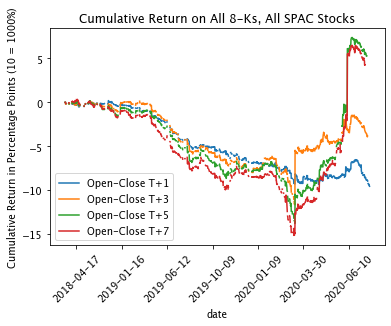

In [122]:
df_returns_all = df_returns_past.append(df_returns_current)
df_returns_all.sort_values(by='date', inplace=True)
df_returns_all.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_returns_all.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_returns_all.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_returns_all.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
plt.title('Cumulative Return on All 8-Ks, All SPAC Stocks');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

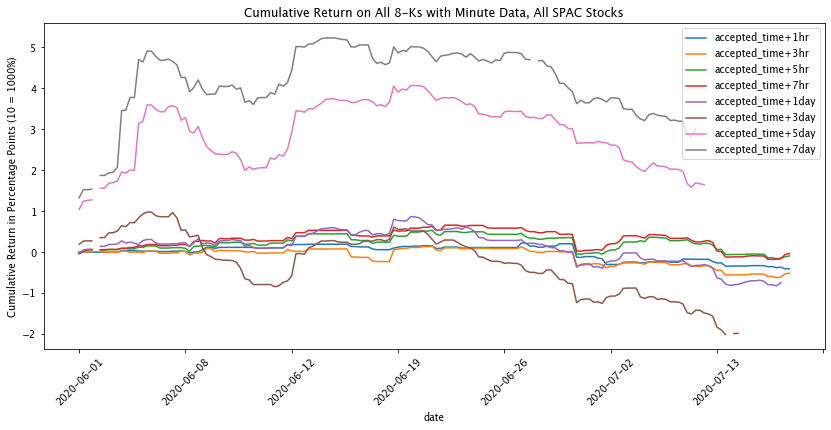

In [123]:
df_returns_all_stocks_minute.sort_values(by='accepted_time', inplace=True)
plt.figure(figsize=(14,6));
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+1hr_%chg'].cumsum().plot(label='accepted_time+1hr')
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+3hr_%chg'].cumsum().plot(label='accepted_time+3hr')
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+5hr_%chg'].cumsum().plot(label='accepted_time+5hr')
df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+7hr_%chg'].cumsum().plot(label='accepted_time+7hr')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+1_%chg'].cumsum().plot(label='accepted_time+1day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+3_%chg'].cumsum().plot(label='accepted_time+3day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+5_%chg'].cumsum().plot(label='accepted_time+5day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+7_%chg'].cumsum().plot(label='accepted_time+7day')
plt.title('Cumulative Return on All 8-Ks with Minute Data, All SPAC Stocks');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

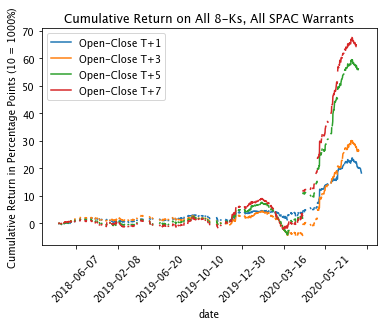

In [124]:
df_returns_all_warrants = df_returns_past_warrants_newticker.append(df_returns_current_warrants)
df_returns_all_warrants.sort_values(by='date', inplace=True)
df_returns_all_warrants.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_returns_all_warrants.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_returns_all_warrants.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_returns_all_warrants.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
plt.title('Cumulative Return on All 8-Ks, All SPAC Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

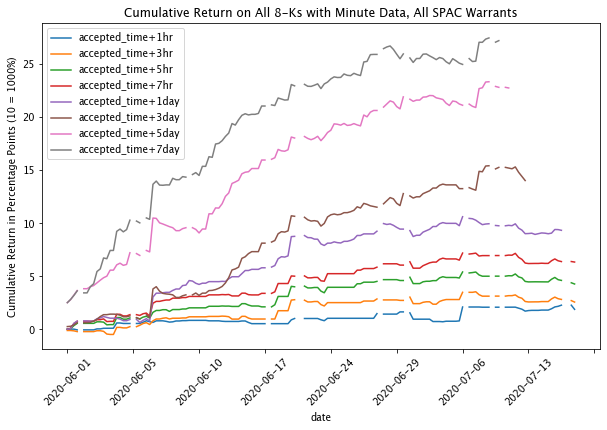

In [125]:
df_returns_all_warrants_minute.sort_values(by='accepted_time', inplace=True)
plt.figure(figsize=(10,6));
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+1hr_%chg'].cumsum().plot(label='accepted_time+1hr')
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+3hr_%chg'].cumsum().plot(label='accepted_time+3hr')
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+5hr_%chg'].cumsum().plot(label='accepted_time+5hr')
df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+7hr_%chg'].cumsum().plot(label='accepted_time+7hr')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+1_%chg'].cumsum().plot(label='accepted_time+1day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+3_%chg'].cumsum().plot(label='accepted_time+3day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+5_%chg'].cumsum().plot(label='accepted_time+5day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+7_%chg'].cumsum().plot(label='accepted_time+7day')
plt.title('Cumulative Return on All 8-Ks with Minute Data, All SPAC Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

# Bag of Words

Predict warrants return using 8-K content

In [527]:
# Useful text:
# "Item 7.01 Regulation FD Disclosure": LOI, Business Combination Agreement, Business Combination consummation
# "Item 5.07 Submission of Matters to a Vote of Security Holders": vote extension, vote result
# key words business combination agreement: "business combination agreement", "business combination", "merger agreement", "purchase agreement"
# key words vote: "special meeting", the "meeting", the "extension", the "extension amendment", the "record date"

# Not useful:
# dropped "item 9.01 financial statements and exhibits"
# maybe drop "Forward-Looking Statements", "No Offer or Solicitation"
# maybe drop "Item 5.02. Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers; Compensatory Arrangements of Certain Officers."

def remove_header_footer(text):
    # remove special characters
    text = text.replace('\t','')
    
    # remove everything in header and footer
    ind_start = text.find('financial accounting standards provided pursuant to section 13(a) of the exchange act')
    ind_end = text.find('signature pursuant to the requirements of the securities exchange act of 1934')
    text = text[ind_start:ind_end]
    
    # additional text to remove
    text_to_remove = [
        'financial accounting standards provided pursuant to section 13(a) of the exchange act'
    ]
    for rm in text_to_remove:
        text = text.replace(rm,'')
    
    return text

def get_item_subheaders(text, subheaders_only):
    # item subheaders. item definitions: https://www.sec.gov/fast-answers/answersform8khtm.html
    subheaders = re.findall('item [0-9]+\.[0-9]+', text)
    subheaders = list(collections.OrderedDict.fromkeys(subheaders)) # handle cases where subheader mentioned in content
    subtexts = []
    for i in range(0,len(subheaders)):
        if i+1==len(subheaders):
            subtext = text[text.find(subheaders[i]):]
        else:
            subtext = text[text.find(subheaders[i]):text.find(subheaders[i+1])]
        if 'item 9.01 financial statements and exhibits' in subtext:
            continue
        else:
            subtexts.append(subtext)
    
    # drop these items
    drop_item_list = ['item 9.01']
    
    if subheaders_only:
        return [x for x in subheaders if x not in drop_item_list]
    return subtexts

def text_processing(text):
    text = remove_header_footer(text)
    subtexts = get_item_subheaders(text, subheaders_only=False)
    tokens = []
    for subtext in subtexts:
        # remove item subheaders. todo: probably should remove text of subheader too
        for item in item_features:
            subtext = subtext.replace(item,'')

        # tokenize, only keeping alphanumeric
        subtokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(subtext)

        # remove stop words
        stop_words = set(nltk.corpus.stopwords.words('english'))
        subtokens = [w for w in subtokens if not w in stop_words]

        # remove numbers and chinese/other non-english characters for now
        # (todo: revisit later for vote count processing)
        subtokens = [w for w in subtokens if w.encode('utf-8').isalpha()]

        # stemming
        stems = [nltk.stem.porter.PorterStemmer().stem(w) for w in subtokens]
        tokens.extend(stems)

    processed_text = ' '.join(tokens)
    return processed_text

# notes:
# 8-Ks aren't actually iid, maybe symbols with previous positive reactions are more likely to positive
# stratify by sector

count 8-Ks: 1020
count 8-Ks after dropping nan prices: 501
count 8-Ks after dropping corrupt symbols: 487 

letter intent features: ['bind letter intent', 'contempl letter intent', 'enter letter intent', 'execut letter intent', 'intent letter intent', 'interest letter intent', 'letter intent', 'letter intent acquir', 'letter intent affili', 'letter intent arya', 'letter intent compani', 'letter intent definit', 'letter intent describ', 'letter intent enter', 'letter intent eo', 'letter intent establish', 'letter intent expect', 'letter intent hereaft', 'letter intent letter', 'letter intent potenti', 'letter intent propos', 'letter intent pursuant', 'letter intent relat', 'letter intent respect', 'letter intent sama', 'letter intent term', 'letter intent triterra', 'term letter intent']


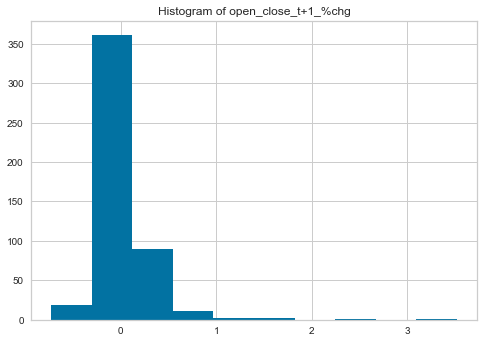

bins [-0.73 -0.3   0.12  0.54  0.97  1.4   1.82  2.24  2.67  3.1   3.52]
counts [ 19. 361.  90.  11.   2.   2.   0.   1.   0.   1.]


In [997]:
y_variable = 'open_close_t+7_%chg'

# get all warrants and drop nan and corrupt symbols
# todo: merge newticker and oldticker df_returns_past_warrants properly. use newticker for now
df_returns_warrants = df_returns_past_warrants_newticker.append(df_returns_current_warrants)
df_returns_warrants = df_returns_warrants[df_returns_warrants.date >= '2019-06-01']
print('count 8-Ks:', len(df_returns_warrants))
df_returns_warrants.dropna(inplace=True)
print('count 8-Ks after dropping nan prices:', len(df_returns_warrants))
# remove corrupt symbols
df_returns_warrants = df_returns_warrants[~df_returns_warrants.symbol.isin(['ACELW','LAZYW'])]
print('count 8-Ks after dropping corrupt symbols:', len(df_returns_warrants), '\n')
df_returns_warrants.sort_values(by='accepted_time', inplace=True)
df_returns_warrants = df_returns_warrants[[y_variable,'symbol','date','text']]
df_returns_warrants.reset_index(inplace=True, drop=True)

# add item subheader binary feature
item_features = ['item 1.01','item 1.02','item 1.03','item 1.04','item 2.01','item 2.02','item 2.03','item 2.04',
                 'item 2.05','item 2.06','item 3.01','item 3.02','item 3.03','item 4.01','item 4.02','item 5.01',
                 'item 5.02','item 5.03','item 5.04','item 5.05','item 5.06','item 5.07','item 5.08','item 6.01',
                 'item 6.02','item 6.03','item 6.04','item 6.05','item 7.01','item 8.01']
for col in item_features:
    df_returns_warrants[col] = 0
for i in range(0, len(df_returns_warrants)):
    text = remove_header_footer(df_returns_warrants.loc[i]['text'])
    items = get_item_subheaders(text, subheaders_only=True)
    for item in items:
        df_returns_warrants.loc[i,item] = 1
        
# process text and append bigram, trigram features
corpus = []
for text in df_returns_warrants['text']:
    corpus.append(text_processing(text))
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 3))
X = vectorizer.fit_transform(corpus)
df_bagofwords = pd.DataFrame(X.toarray())
df_bagofwords.columns = vectorizer.get_feature_names()
df_returns_warrants = pd.concat([df_returns_warrants, df_bagofwords], axis=1)

# example features
print('letter intent features:', [x for x in df_bagofwords.columns if 'letter intent' in x])

# histogram
(n, bins, patches) = plt.hist(df_returns_warrants[y_variable], bins=10, label=y_variable)
plt.title('Histogram of ' + y_variable)
plt.show()
print('bins', np.round(bins,2))
print('counts', n)

#### Binary Classification

In [1012]:
def binary_classification_eval_metrics(model, X_train, X_test, y_train, y_test, feature_importance=True):
    print('############\nTraining set\n############')
    y_pred_train = model.predict(X_train)
    print('% predicted positive labels:', np.round(sum(y_pred_train)/len(y_pred_train), 2))
    print('% actual positive labels:', np.round(sum(y_train)/len(y_train), 2))
    print('accuracy:', np.round(model.score(X_train, y_train),2))
    cm = confusion_matrix(y_train, y_pred_train)
    print('confusion matrix:\n', cm)
    print(classification_report(y_train, y_pred_train, target_names=['0','1']))
    metrics.plot_roc_curve(model, X_train, y_train);
    plt.title('ROC curve (train)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X_train, y_train)
    plt.title('Precision-recall curve (train)');
    plt.show()
    
    print('#########\nTest set\n#########')
    y_pred = model.predict(X_test)
    print('% predicted positive labels:', np.round(sum(y_pred)/len(y_pred), 2))
    print('% actual positive labels:', np.round(sum(y_test)/len(y_test), 2))
    print('accuracy:', np.round(model.score(X_test, y_test),2))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix:\n', cm)
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    metrics.plot_roc_curve(model, X_test, y_test);
    plt.title('ROC curve (test)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    plt.title('Precision-recall curve (test)');
    plt.show()
    
    # feature importance
    if feature_importance:
        try:
            coefs = model.coef_[0]
        except:
            coefs = model.feature_importances_
        indices = np.argsort(np.abs(coefs))[::-1]
        print('count nonzero features:', len(X.columns[coefs!=0]))
        top_n_features = 20 #len(X.columns[coefs!=0])
        plt.bar(range(top_n_features), coefs[indices[:top_n_features]], align='center')
        plt.xticks(range(top_n_features), X.columns[indices[:top_n_features]], rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.3)
        plt.title('Feature importance')
        plt.show()

In [1013]:
# inputs
label_threshold = 0.05
min_word_freq = 3
n_lsa = 100

# prep data
X = df_returns_warrants.drop([y_variable,'symbol','date','text'], axis=1)
print('count features:', len(X.columns))
X = X[X.columns[X.sum() > min_word_freq].tolist()] # min word frequency
print('count features > min_word_freq:', len(X.columns))
lsa = TruncatedSVD(n_components=n_lsa, n_iter=10, random_state=123) # lsa dimension reduction
X = pd.DataFrame(lsa.fit_transform(X), columns=['lsa'+str(i) for i in range(0,n_lsa)])
print('count feature after LSA:', len(X.columns), '\n')
y = np.where(df_returns_warrants[y_variable] > label_threshold, 1, 0) # label threshold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('training dim:', X_train.shape)
print('testing dim:', X_test.shape, '\n')
print('count 0:', np.sum(y==0))
print('count 1:', np.sum(y==1))

count features: 225145
count features > min_word_freq: 29069
count feature after LSA: 100 

training dim: (389, 100)
testing dim: (98, 100) 

count 0: 328
count 1: 159


Logistic Regression

Best 5-fold CV (TimeSeriesSplit) score: 0.474987 using {'C': 10} 



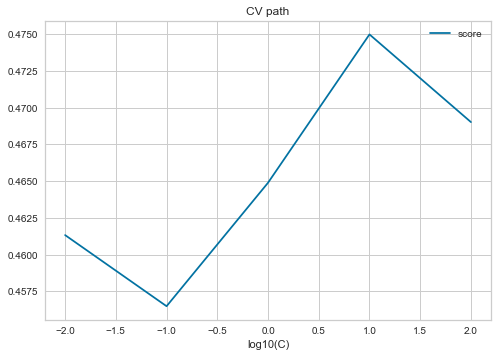

############
Training set
############
% predicted positive labels: 0.2
% actual positive labels: 0.33
accuracy: 0.78
confusion matrix:
 [[243  19]
 [ 67  60]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       262
           1       0.76      0.47      0.58       127

    accuracy                           0.78       389
   macro avg       0.77      0.70      0.72       389
weighted avg       0.78      0.78      0.76       389



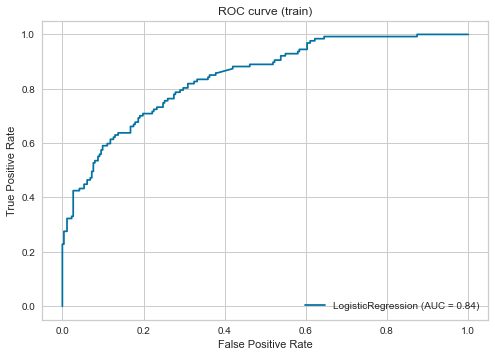

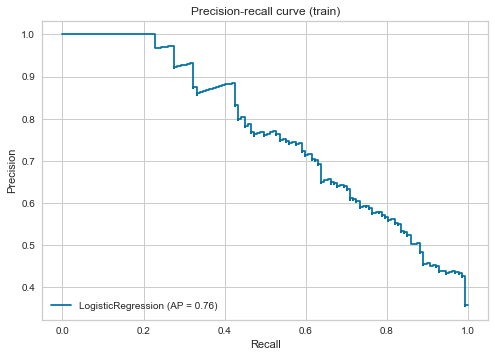

#########
Test set
#########
% predicted positive labels: 0.22
% actual positive labels: 0.33
accuracy: 0.61
confusion matrix:
 [[52 14]
 [24  8]]
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        66
           1       0.36      0.25      0.30        32

    accuracy                           0.61        98
   macro avg       0.52      0.52      0.51        98
weighted avg       0.58      0.61      0.59        98



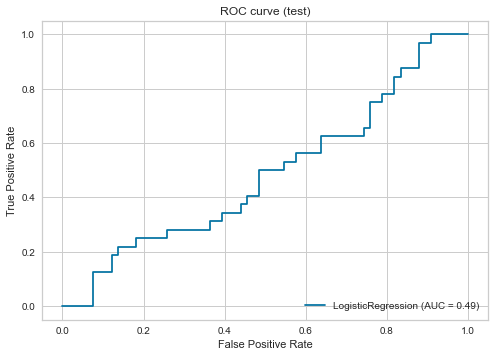

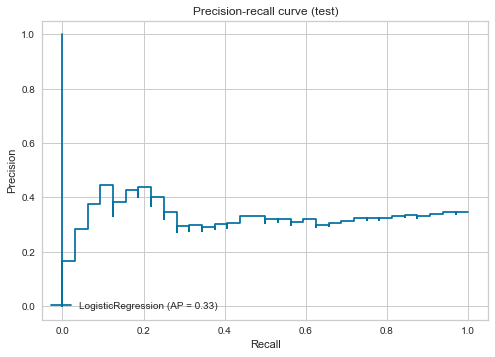

count nonzero features: 97


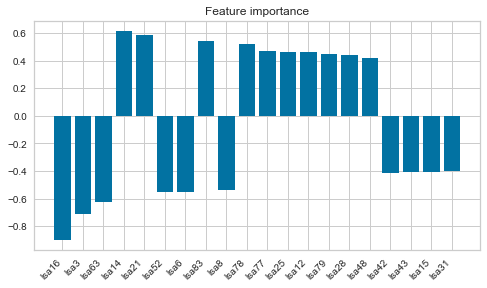

In [1000]:
print('Logistic Regression\n')

# CV
model_lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
C = [.01, .1, 1, 10, 100]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_lr, param_grid, scoring='roc_auc', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_lr = LogisticRegression(penalty='l1', solver='liblinear', C=grid_result.best_params_['C'], max_iter=1000)
model_lr.fit(X_train, y_train)
binary_classification_eval_metrics(model_lr, X_train, X_test, y_train, y_test)

Decision Tree

Best 5-fold CV (TimeSeriesSplit) score: 0.577287 using {'max_depth': 17} 



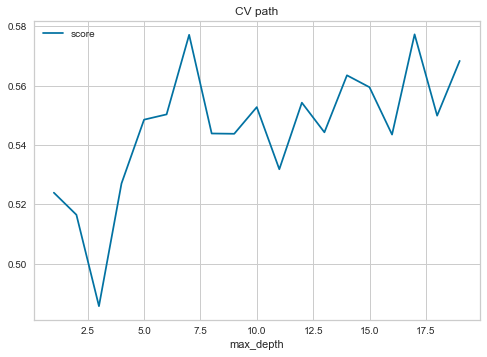

############
Training set
############
% predicted positive labels: 0.32
% actual positive labels: 0.33
accuracy: 0.99
confusion matrix:
 [[262   0]
 [  3 124]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       262
           1       1.00      0.98      0.99       127

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



#########
Test set
#########
% predicted positive labels: 0.29
% actual positive labels: 0.33
accuracy: 0.57
confusion matrix:
 [[47 19]
 [23  9]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        66
           1       0.32      0.28      0.30        32

    accuracy                           0.57        98
   macro avg       0.50      0.50      0.50        98
weighted avg       0.56      0.57      0.56        98



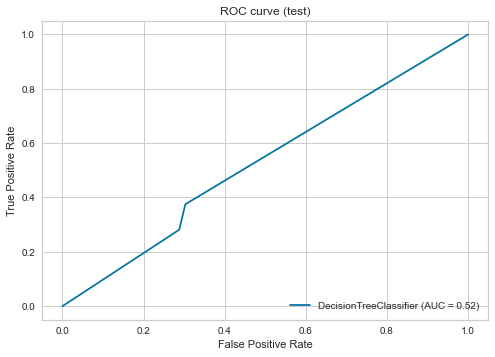

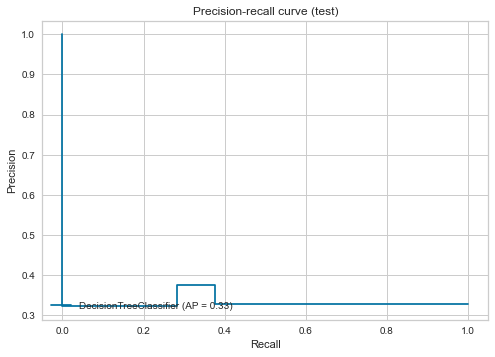

count nonzero features: 42


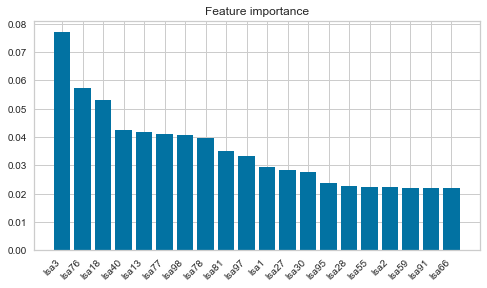

In [1001]:
print('Decision Tree\n')

# CV
model_dt = DecisionTreeClassifier()
max_depth = list(range(1, 20))
param_grid = dict(max_depth=max_depth)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_dt, param_grid, scoring='roc_auc', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'max_depth': max_depth})
reg_path.plot(x='max_depth')
plt.title('CV path')
plt.xlabel('max_depth')
plt.show()

# model
model_dt = DecisionTreeClassifier(max_depth=grid_result.best_params_['max_depth'])
model_dt.fit(X_train, y_train)
binary_classification_eval_metrics(model_dt, X_train, X_test, y_train, y_test)

# tree diagram
# tree_data = export_graphviz(model_dt, out_file=None, feature_names=X.columns, class_names=['-1','1'],
#                             filled=True, rounded=True, rotate=True, impurity=False)
# graph = graphviz.Source(tree_data)
# graph

Random Forest

Best 5-fold CV (TimeSeriesSplit) score: 0.568914 using {'max_depth': 2, 'max_features': 0.05, 'min_samples_leaf': 0.05, 'n_estimators': 8} 

############
Training set
############
% predicted positive labels: 0.0
% actual positive labels: 0.33
accuracy: 0.67
confusion matrix:
 [[261   1]
 [127   0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       262
           1       0.00      0.00      0.00       127

    accuracy                           0.67       389
   macro avg       0.34      0.50      0.40       389
weighted avg       0.45      0.67      0.54       389



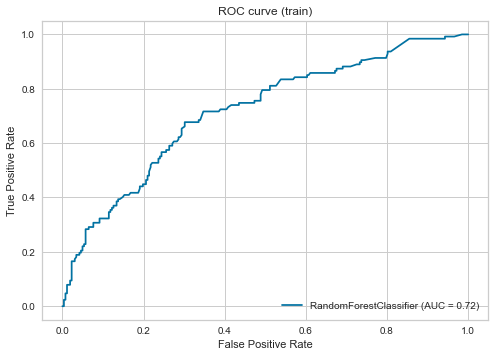

#########
Test set
#########
% predicted positive labels: 0.0
% actual positive labels: 0.33
accuracy: 0.67
confusion matrix:
 [[66  0]
 [32  0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        66
           1       0.00      0.00      0.00        32

    accuracy                           0.67        98
   macro avg       0.34      0.50      0.40        98
weighted avg       0.45      0.67      0.54        98



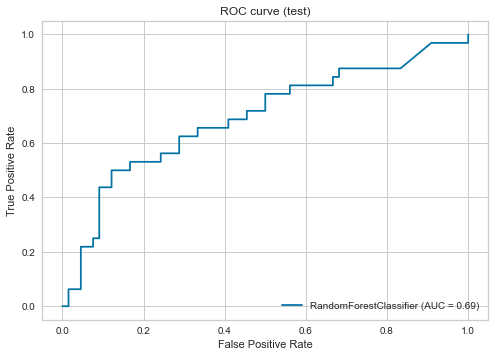

count nonzero features: 18


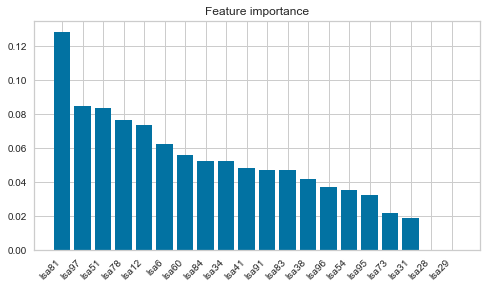

In [1021]:
print('Random Forest\n')

# CV
model_rf = RandomForestClassifier()
n_estimators = list(range(5, 10))
max_depth = list(range(1, 5))
min_samples_leaf = [.05, .1, .2]
max_features = [.05, .1]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_rf, param_grid, scoring='roc_auc', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')

# model
model_rf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                  max_depth=grid_result.best_params_['max_depth'],
                                  min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                  max_features=grid_result.best_params_['max_features'])
model_rf.fit(X_train, y_train)
binary_classification_eval_metrics(model_rf, X_train, X_test, y_train, y_test)

SVM

Best 5-fold CV (TimeSeriesSplit) score: 0.545135 using {'C': 0.1} 



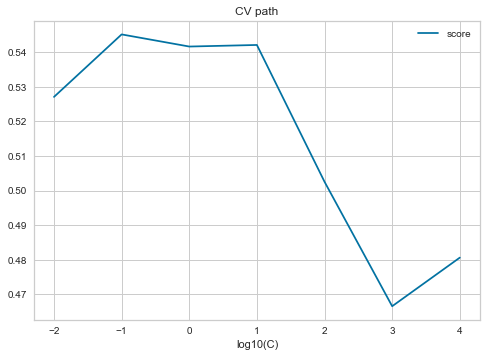

############
Training set
############
% predicted positive labels: 0.0
% actual positive labels: 0.33
accuracy: 0.67
confusion matrix:
 [[262   0]
 [127   0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       262
           1       0.00      0.00      0.00       127

    accuracy                           0.67       389
   macro avg       0.34      0.50      0.40       389
weighted avg       0.45      0.67      0.54       389



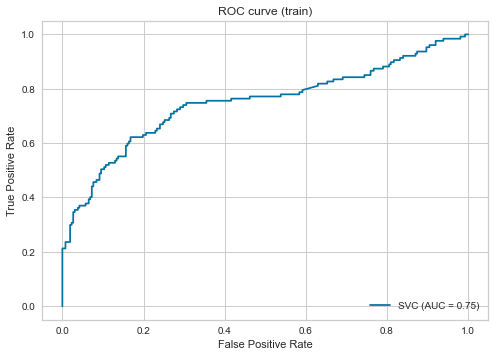

#########
Test set
#########
% predicted positive labels: 0.0
% actual positive labels: 0.33
accuracy: 0.67
confusion matrix:
 [[66  0]
 [32  0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        66
           1       0.00      0.00      0.00        32

    accuracy                           0.67        98
   macro avg       0.34      0.50      0.40        98
weighted avg       0.45      0.67      0.54        98



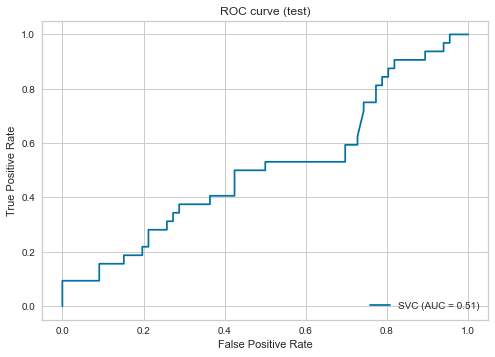

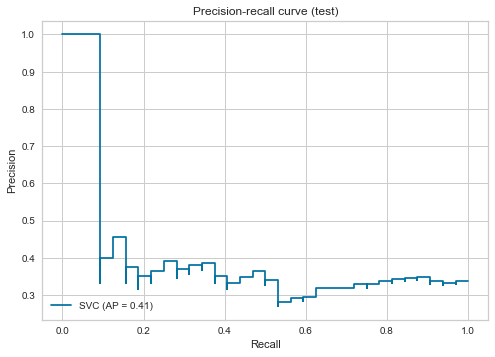

In [1003]:
print('SVM\n')

# CV
model_svm = SVC(kernel='rbf')
C = [.01, .1, 1, 10, 100, 1000, 10000]
# C = [.6, .7, .8, .9, 1, 1.1, 1.2]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_svm, param_grid, scoring='roc_auc', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_svm = SVC(kernel='rbf', C=grid_result.best_params_['C'])
model_svm.fit(X_train, y_train)
binary_classification_eval_metrics(model_svm, X_train, X_test, y_train, y_test, feature_importance=False)

#### 3-Class Classification

In [1004]:
def get_multi_labels(x):
    if x < first_label_threshold:
        return -1
    elif x > second_label_threshold:
        return 1
    else:
        return 0
    
def plot_roc_multi(model_multi, X_input, y_input):
    y_binarized = preprocessing.label_binarize(y_input, classes=[-1, 0, 1])
    n_classes = y_binarized.shape[1]
    fpr = dict()
    tpr = dict()
    from itertools import cycle
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_binarized[:, i], model_multi.predict_proba(X_input)[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
def multi_classification_eval_metrics(model_multi, X_train, X_test, y_train, y_test, feature_importance=True):
    print('############\nTraining set\n############')
    y_pred_train = model_multi.predict(X_train)
    print('% predicted (actual) -1 labels: {} ({})'.format(np.round(sum(y_pred_train==-1)/len(y_pred_train), 2),
                                                           np.round(sum(y_train==-1)/len(y_train), 2)))
    print('% predicted (actual) 0 labels: {} ({})'.format(np.round(sum(y_pred_train==0)/len(y_pred_train), 2),
                                                          np.round(sum(y_train==0)/len(y_train), 2)))
    print('% predicted (actual) 1 labels: {} ({})'.format(np.round(sum(y_pred_train==1)/len(y_pred_train), 2),
                                                          np.round(sum(y_train==1)/len(y_train), 2)))
    print('accuracy:', np.round(model_multi.score(X_train, y_train),2))
    cm = confusion_matrix(y_train, y_pred_train)
    print('confusion matrix:\n', cm)
    print(classification_report(y_train, y_pred_train, target_names=['-1','0','1']))
    plot_roc_multi(model_multi, X_train, y_train)

    print('#########\nTest set\n#########')
    y_pred = model_multi.predict(X_test)
    print('% predicted (actual) -1 labels: {} ({})'.format(np.round(sum(y_pred==-1)/len(y_pred), 2),
                                                           np.round(sum(y_test==-1)/len(y_test), 2)))
    print('% predicted (actual) 0 labels: {} ({})'.format(np.round(sum(y_pred==0)/len(y_pred), 2),
                                                          np.round(sum(y_test==0)/len(y_test), 2)))
    print('% predicted (actual) 1 labels: {} ({})'.format(np.round(sum(y_pred==1)/len(y_pred), 2),
                                                          np.round(sum(y_test==1)/len(y_test), 2)))
    print('accuracy:', np.round(model_multi.score(X_test, y_test),2))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix:\n', cm) # x-axis is actual, y-axis predicted
    print(classification_report(y_test, y_pred, target_names=['-1','0','1']), '\n')
    plot_roc_multi(model_multi, X_test, y_test)

    # feature importance
    if feature_importance:
        try:
            coefs = model_multi.coef_[0]
        except:
            coefs = model_multi.feature_importances_
        indices = np.argsort(np.abs(coefs))[::-1]
        print('count nonzero features:', len(X.columns[coefs!=0]))
        top_n_features = 20 #len(X.columns[coefs!=0])
        plt.bar(range(top_n_features), coefs[indices[:top_n_features]], align='center')
        plt.xticks(range(top_n_features), X.columns[indices[:top_n_features]], rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.3)
        plt.title('Feature importance')
        plt.show()

In [1005]:
# inputs
first_label_threshold = -0.05 #-0.17
second_label_threshold = 0.05 #0.38
min_word_freq = 3
n_lsa = 100

# prep data
X = df_returns_warrants.drop([y_variable,'symbol','date','text'], axis=1)
print('count features:', len(X.columns))
X = X[X.columns[X.sum() > min_word_freq].tolist()] # min word frequency
print('count features > min_word_freq:', len(X.columns))
lsa = TruncatedSVD(n_components=n_lsa, n_iter=10, random_state=123) # lsa dimension reduction
X = pd.DataFrame(lsa.fit_transform(X), columns=['lsa'+str(i) for i in range(0,n_lsa)])
print('count feature after LSA:', len(X.columns), '\n')
y = df_returns_warrants[y_variable].map(get_multi_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('training dim:', X_train.shape)
print('testing dim:', X_test.shape, '\n')
print('count -1:', np.sum(y==-1))
print('count 0:', np.sum(y==0))
print('count 1:', np.sum(y==1), '\n')

count features: 225145
count features > min_word_freq: 29069
count feature after LSA: 100 

training dim: (389, 100)
testing dim: (98, 100) 

count -1: 136
count 0: 192
count 1: 159 



Logistic Regression

Best 5-fold CV (TimeSeriesSplit) score: 0.389217 using {'C': 10}


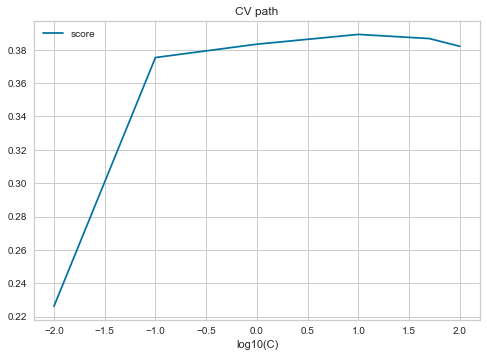

############
Training set
############
% predicted (actual) -1 labels: 0.26 (0.29)
% predicted (actual) 0 labels: 0.41 (0.38)
% predicted (actual) 1 labels: 0.33 (0.33)
accuracy: 0.58
confusion matrix:
 [[63 20 30]
 [20 96 33]
 [17 44 66]]
              precision    recall  f1-score   support

          -1       0.63      0.56      0.59       113
           0       0.60      0.64      0.62       149
           1       0.51      0.52      0.52       127

    accuracy                           0.58       389
   macro avg       0.58      0.57      0.58       389
weighted avg       0.58      0.58      0.58       389



#########
Test set
#########
% predicted (actual) -1 labels: 0.31 (0.23)
% predicted (actual) 0 labels: 0.32 (0.44)
% predicted (actual) 1 labels: 0.38 (0.33)
accuracy: 0.36
confusion matrix:
 [[ 8  3 12]
 [15 15 13]
 [ 7 13 12]]
              precision    recall  f1-score   support

          -1       0.27      0.35      0.30        23
           0       0.48      0.35      0.41        43
           1       0.32      0.38      0.35        32

    accuracy                           0.36        98
   macro avg       0.36      0.36      0.35        98
weighted avg       0.38      0.36      0.36        98
 



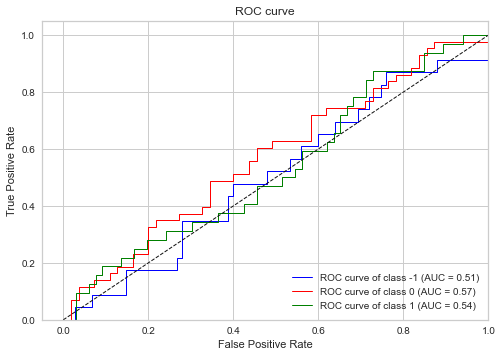

count nonzero features: 100


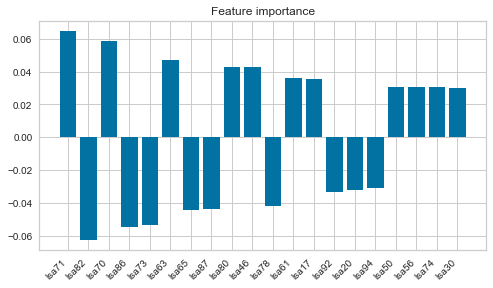

In [1006]:
print('Logistic Regression\n')

# CV
model_lr_multi = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial')
C = [.01, .1, 1, 10, 50, 100]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_lr_multi, param_grid, scoring=metrics.make_scorer(metrics.f1_score, average='macro'),
                           cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_lr_multi = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial',
                                    C=grid_result.best_params_['C'])
model_lr_multi.fit(X_train, y_train)
multi_classification_eval_metrics(model_lr_multi, X_train, X_test, y_train, y_test)

Decision Tree

Best 5-fold CV (TimeSeriesSplit) score: 0.554614 using {'max_depth': 12} 



############
Training set
############
% predicted (actual) -1 labels: 0.27 (0.29)
% predicted (actual) 0 labels: 0.41 (0.38)
% predicted (actual) 1 labels: 0.32 (0.33)
accuracy: 0.97
confusion matrix:
 [[104   7   2]
 [  0 149   0]
 [  0   3 124]]
              precision    recall  f1-score   support

          -1       1.00      0.92      0.96       113
           0       0.94      1.00      0.97       149
           1       0.98      0.98      0.98       127

    accuracy                           0.97       389
   macro avg       0.97      0.97      0.97       389
weighted avg       0.97      0.97      0.97       389



#########
Test set
#########
% predicted (actual) -1 labels: 0.36 (0.23)
% predicted (actual) 0 labels: 0.32 (0.44)
% predicted (actual) 1 labels: 0.33 (0.33)
accuracy: 0.44
confusion matrix:
 [[13  3  7]
 [16 16 11]
 [ 6 12 14]]
              precision    recall  f1-score   support

          -1       0.37      0.57      0.45        23
           0       0.52      0.37      0.43        43
           1       0.44      0.44      0.44        32

    accuracy                           0.44        98
   macro avg       0.44      0.46      0.44        98
weighted avg       0.46      0.44      0.44        98
 



count nonzero features: 59


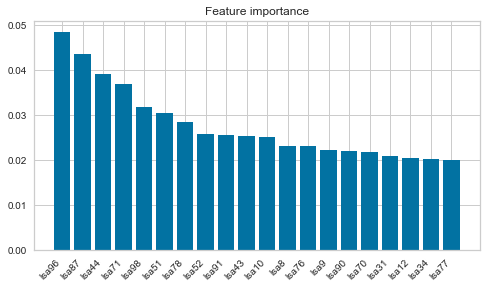

In [1007]:
print('Decision Tree\n')

# CV
model_dt_multi = DecisionTreeClassifier()
max_depth = list(range(1, 20))
param_grid = dict(max_depth=max_depth)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_dt_multi, param_grid, scoring='roc_auc', cv=kfold, verbose=0, n_jobs=5)
y_train_binarized = preprocessing.label_binarize(y_train, classes=[-1, 0, 1])
grid_result = grid_search.fit(X_train, y_train_binarized)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'max_depth': max_depth})
reg_path.plot(x='max_depth')
plt.title('CV path')
plt.xlabel('max_depth')
plt.show()

# model
model_dt_multi = DecisionTreeClassifier(max_depth=grid_result.best_params_['max_depth'])
model_dt_multi.fit(X_train, y_train)
multi_classification_eval_metrics(model_dt_multi, X_train, X_test, y_train, y_test)

# tree diagram
# tree_data = export_graphviz(model_dt_multi, out_file=None, feature_names=X.columns, class_names=['-1','0','1'],
#                             filled=True, rounded=True, rotate=True, impurity=False)
# graph = graphviz.Source(tree_data)
# graph

Random Forest

Best 5-fold CV (TimeSeriesSplit) score: 0.597820 using {'max_depth': 13, 'min_samples_leaf': 0.001, 'n_estimators': 7} 

############
Training set
############
% predicted (actual) -1 labels: 0.29 (0.29)
% predicted (actual) 0 labels: 0.4 (0.38)
% predicted (actual) 1 labels: 0.31 (0.33)
accuracy: 0.93
confusion matrix:
 [[104   8   1]
 [  4 141   4]
 [  4   7 116]]
              precision    recall  f1-score   support

          -1       0.93      0.92      0.92       113
           0       0.90      0.95      0.92       149
           1       0.96      0.91      0.94       127

    accuracy                           0.93       389
   macro avg       0.93      0.93      0.93       389
weighted avg       0.93      0.93      0.93       389



#########
Test set
#########
% predicted (actual) -1 labels: 0.28 (0.23)
% predicted (actual) 0 labels: 0.4 (0.44)
% predicted (actual) 1 labels: 0.33 (0.33)
accuracy: 0.33
confusion matrix:
 [[ 6  9  8]
 [13 16 14]
 [ 8 14 10]]
              precision    recall  f1-score   support

          -1       0.22      0.26      0.24        23
           0       0.41      0.37      0.39        43
           1       0.31      0.31      0.31        32

    accuracy                           0.33        98
   macro avg       0.31      0.32      0.31        98
weighted avg       0.33      0.33      0.33        98
 



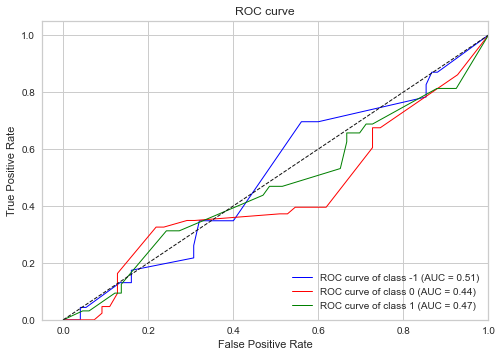

count nonzero features: 99


In [1010]:
print('Random Forest\n')

# CV
model_rf_multi = RandomForestClassifier()
n_estimators = list(range(5, 20))
max_depth = list(range(1, 20))
min_samples_leaf = [.001, .01, .1]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_rf_multi, param_grid, scoring='roc_auc', cv=kfold, verbose=0, n_jobs=5)
y_train_binarized = preprocessing.label_binarize(y_train, classes=[-1, 0, 1])
grid_result = grid_search.fit(X_train, y_train_binarized)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')

# model
model_rf_multi = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                        max_depth=grid_result.best_params_['max_depth'],
                                        min_samples_leaf=grid_result.best_params_['min_samples_leaf'])
model_rf_multi.fit(X_train, y_train)
multi_classification_eval_metrics(model_rf_multi, X_train, X_test, y_train, y_test)

SVM

Best 5-fold CV (TimeSeriesSplit) score: -1.095221 using {'C': 0.01} 



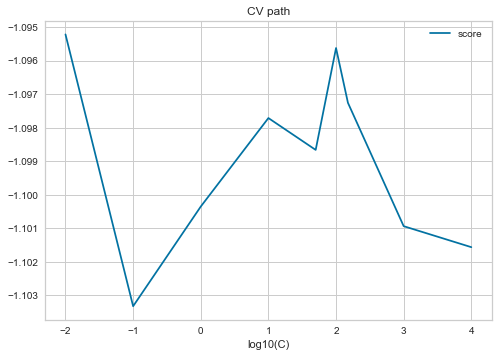

############
Training set
############
% predicted (actual) -1 labels: 0.0 (0.29)
% predicted (actual) 0 labels: 1.0 (0.38)
% predicted (actual) 1 labels: 0.0 (0.33)
accuracy: 0.38
confusion matrix:
 [[  0 113   0]
 [  0 149   0]
 [  0 127   0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       113
           0       0.38      1.00      0.55       149
           1       0.00      0.00      0.00       127

    accuracy                           0.38       389
   macro avg       0.13      0.33      0.18       389
weighted avg       0.15      0.38      0.21       389



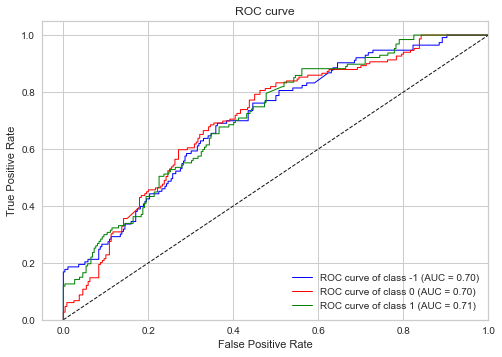

#########
Test set
#########
% predicted (actual) -1 labels: 0.0 (0.23)
% predicted (actual) 0 labels: 1.0 (0.44)
% predicted (actual) 1 labels: 0.0 (0.33)
accuracy: 0.44
confusion matrix:
 [[ 0 23  0]
 [ 0 43  0]
 [ 0 32  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        23
           0       0.44      1.00      0.61        43
           1       0.00      0.00      0.00        32

    accuracy                           0.44        98
   macro avg       0.15      0.33      0.20        98
weighted avg       0.19      0.44      0.27        98
 



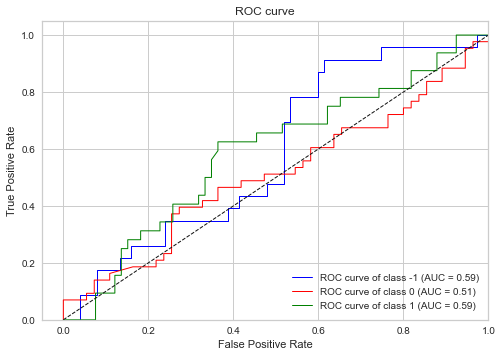

In [1009]:
print('SVM\n')

# CV
model_svm_multi = SVC(kernel='rbf', probability=True)
C = [.01, .1, 1, 10, 50, 100, 150, 1000, 10000]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_svm_multi, param_grid, scoring='neg_log_loss', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_svm_multi = SVC(kernel='rbf', C=grid_result.best_params_['C'], probability=True)
model_svm_multi.fit(X_train, y_train)
multi_classification_eval_metrics(model_svm_multi, X_train, X_test, y_train, y_test, feature_importance=False)